# Goal 

The goal of this notebook is to predict the houses prices and figure out what is the best model to do that. 

Most of the functions used in this notebook are in the *daftmodel.py* module.

# Data

## Import Libraries and Set Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   PolynomialFeatures, PowerTransformer)
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from daftpy.daftmodel import (split_data, scores_statistics, metrics_regression, 
                              plot_learning_curves, compare_models, residuals, 
                              transformer_estimator, IdentityTransformer, get_weigts, plot_metrics,
                             get_base_predictions, comp_met)

from yellowbrick.regressor import ResidualsPlot
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor

import joblib

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Load Data

In [3]:
data = pd.read_csv('data/selected_data.csv', sep=',')
data.shape 

(7344, 9)

-------------

**Clusters** (Fail)

As indicated in the notebook *Clustering_Real_Estate_Data* the data below have been used to try to improve the performance of the algorithms. However, the results were a little bit worse so it has been quited (raw cells). The mean absolute errors with the cluster variable are shown at the end of the notebook, just for comparation.

-------------

**Predictors**

Below you can see the predictors that I will use.

In [4]:
# Numeric features
num_features = list(data.select_dtypes('number').columns) #X_train
num_features.remove('price')
# num_features.remove('longitude')
# num_features.remove('latitude')

# Categorical features
cat_features =  list(data.select_dtypes('object').columns)
cat_features.remove('city_district')

# Make DataFrames to present the features
num_feat_df = pd.DataFrame({'numerical': num_features}) 
cat_feat_df = pd.DataFrame({'categorical': cat_features})

# Merge both DataFrames
feat_df = num_feat_df.merge(cat_feat_df, how='left', left_index=True, right_index=True).fillna(' ')
feat_df

,numerical,categorical
0,floor_area,place
1,bedroom,type_house
2,bathroom,
3,longitude,
4,latitude,


**Categorical Predictors Levels**

In [5]:
# Add `Unknown` to give it to missing values and not have an error  with levels
levels_type_house = list(data.type_house.unique())
levels_type_house.append('Unknown')
levels_type_house.remove(np.nan)
#levels_type_house = np.append(levels_type_house, 'Unknown')
levels_place = list(data.place.unique())
levels_place.append('Unknown')
levels_place.remove(np.nan)
# print(levels_place.shape)
# levels_city_district = data.city_district.unique()

cat_feat_df['n_levels'] = [len(levels_place), len(levels_type_house)] #, levels_city_district
cat_feat_df['sample'] = [levels_place[:5], levels_type_house] #, levels_city_district[:4]
cat_feat_df # mejorar

,categorical,n_levels,sample
0,place,137,"[Naas, Wexford, Dublin 8, Dublin 6W, Carrick o..."
1,type_house,3,"[house, apartment, Unknown]"


**Missing Values**

In [6]:
data.isna().sum()

price               0
floor_area          0
bedroom             0
bathroom            0
place            1208
type_house        471
longitude           0
latitude            0
city_district     355
dtype: int64

There is no missing values in the numeric data.

## Split Data

In [7]:
features = [
    'price',
    'floor_area',
    'latitude',
    'longitude',
    'bedroom',
    'bathroom',
    'type_house',
#    'city_district',
    'place',
#    'cluster'
]

data = data[features].copy()
data.shape

(7344, 8)

In [8]:
# Mean prices to build the Baseline Model
# It is needed calculating it befor splitting the data
mean_prices = data.groupby('place')[['price','place']].mean().sort_values('price', ascending=False)
mean_prices.head(3)

,price
place,
Dublin 6,1.047290e+06
Dun Laoghaire,8.952080e+05
Dublin 4,8.143643e+05


-------------

**Drop Missing Values** (Fail)

Dropping missing values ends in a significant lost of performance. Because of that, the missing values will be handle in another way. The metrics having dropped the missing values are at the end of the notebook.

-------------

The `split_data()` function lets us spliting the data in several ways if I wish.

In [9]:
X_train, X_test, y_train, y_test = split_data(data=data, 
                                              target='price', 
                                              test_size=.15, 
                                              output='X_y_train_test',
                                              random_state=7)

X_train: (6242, 7) 
X_test: (1102, 7) 
y_train: (6242,) 
y_test: (1102,) 



# Metrics

I will use the following metrics to evaluate the models:

In [10]:
# It will be used in the `scores_statistics()` function
scoring = {'r2': 'r2', 
           'MAE': 'neg_mean_absolute_error', 
           'MAPE': 'neg_mean_absolute_percentage_error', 
           'RMSE': 'neg_root_mean_squared_error'}

# Missing Values Treatment And Transformations

The missing values are handle through the `transformer_estimator()` function. Below you can see the performance for the best model according to different combinations of missing values traetment. 

As there is no missinga values in the numeric data it is not possible to the improve the performance by modifying the SimpleImputer strategy for numeric data. But it is possible to modify the strategy for categorical data as the `place` and `type_house` features have missing values.

Voting Regressor 2 MAE:
- `None`: 68,951€
- `most_frequent`: 69,020€

Strategy:
- Numeric data: Nothing, there is no missing values.
- Categorical data: fill with `None`

**Transformations**
- Numeric data: 

# Models

## Baseline Model

The baseline model consist in taking the mean price in the corresponding place as the prediction price for a house. If there are missing values in the `place` column it will be missing values in the predictions so the `get_base_predictions()` function will fill them with the mean price for Ireland.

I will use this model's performance to compare with the other ones.

In [11]:
print('Performance on the training set:\n', '-'*10)
y_pred_train = get_base_predictions(mean_prices=mean_prices, data_to_predict=X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

metrics_to_plot = {}
print('Performance on the test set:\n', '-'*10)
y_pred = get_base_predictions(mean_prices=mean_prices, data_to_predict=X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

# Add metrics to the dictionary to plot it 
metrics_to_plot['Baseline Model'] = metrics

Performance on the training set:
 ----------
R²: 0.3366146919030736
MAE: 157537.5281846715
MAPE: 0.5009050686059635
RMSE: 247639.9117981296
R (corr): 0.581197357024071

Performance on the test set:
 ----------
R²: 0.23766197391151822
MAE: 149689.27015807052
MAPE: 0.5023062442705521
RMSE: 222662.44453701816
R (corr): 0.5102568176397978



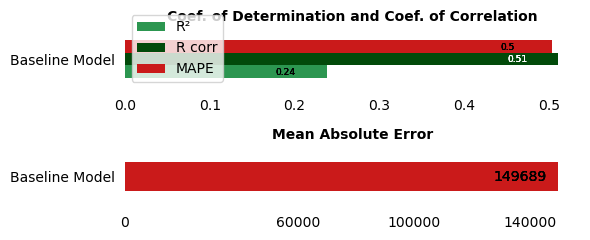

In [12]:
plot_metrics(metrics_to_plot)

## Multiple Linear Regression

I will use the `transformer_estimator` function to encoder categorical variables, transform numerical variables and input the median to numerical variables and fill with `None` categorical ones with missing values.

Then I will use the `scores_statistics` function to plot the metrics after doing cross validation.

In [13]:
lr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                          levels_list=[levels_place, 
                                                       levels_type_house],
                                          regressor=LinearRegression(), 
                                          poly_degree=1, 
                                          num_feat=num_features,
                                          cat_feat=cat_features)

scores_lr, scores_resume_lr = scores_statistics(estimator=lr_pipe_estimator, 
                                                scoring_dict=scoring, 
                                                X_train=X_train, 
                                                y_train=y_train, 
                                                cv=5, 
                                                return_train_score=False)

r2 mean: 0.637434998100077
r2 std: 0.012912197238422097 

MAE mean: -114418.88769922775
MAE std: 3394.1393875659664 

MAPE mean: -0.3654357868488225
MAPE std: 0.010585515465533851 

RMSE mean: -182740.44742182258
RMSE std: 12436.192751932243 



Above you can see the resulting metrics using cross validation. 

### Overfitting Analysis

Now I will check whether there is overfitting or not by calculating the metrics for the train and test sets. I will use the `metrics_regression` function to do that.

In [14]:
lr = lr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = lr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = lr.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Linear Regression'] = metrics

Performance on the training set:
 ----------
R²: 0.6551712152371808
MAE: 111219.00175289037
MAPE: 0.35359339787189775
RMSE: 178541.62037926153
R (corr): 0.8094264730271559

Performance on the test set:
 ----------
R²: 0.6085208927666308
MAE: 106647.88307864872
MAPE: 0.3587548698817349
RMSE: 159561.26682627705
R (corr): 0.7884621080119696



Mean absolute error in the train set is only 5,000€ greater than in the test set so we can consider that there is not overfitting.

**Intercept**

In [15]:
lr.steps[1][1].intercept_

356030.1985221802

**Coeficients**

In [16]:
# lr.steps[1][1].coef_

### Residuals Diagnostic

The `residuals` function plots the actual values against the predicted ones in addition to the residuals. This will help us to understand how the model is working.

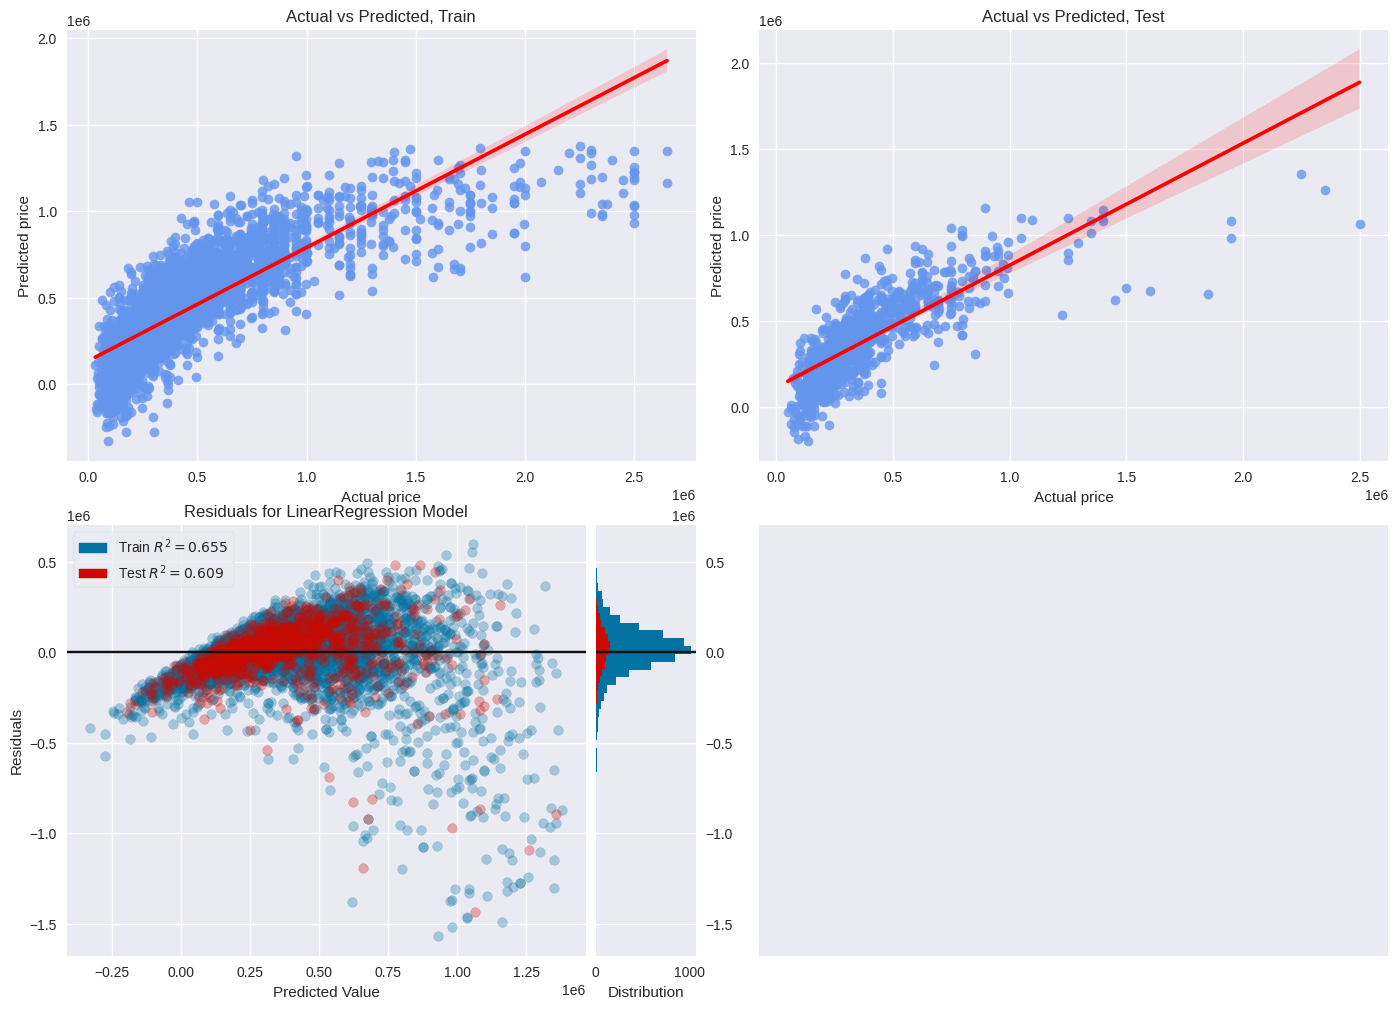

In [17]:
residuals(lr_pipe_estimator, X_train, X_test, y_train, y_test)

**Conclusions**

The residuals are calculated extracting `y_train` from `y_pred_train`: **residuals = y_pred_train - y_train**

- The model predices a few negative values, which is not possible in the real world.
- The model doesn't predice well the price of expensive houses. When a house is very expensive the model tends to understimate it.
- We can consider that there is not overfitting.

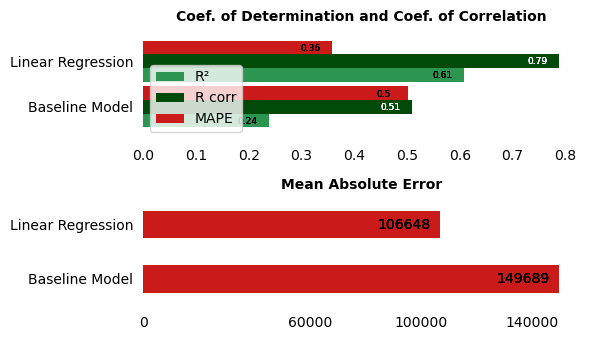

In [18]:
plot_metrics(metrics_to_plot)

A simple linear regression model improve the metrics a lot. Now the MAE is 43,000€ lower!

In [19]:
comp_met(metrics_to_plot, 'Linear Regression', 'Baseline Model')

Improvement respect Baseline Model: 43041€ -> 29%
Improvement respect Last Best Model: 43041€ -> 29%


A simple linear regression model improve the metrics a lot. Now the MAE is 43,000€ lower!

|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|43,041€||
|29%||

## Polynomial Regression

First I will instance the GridSearchCV class and fit it to the training set to figure out the best hyperparameters. In this case I will try only different degrees to see what polinomial regression is the best.

In [20]:
poly_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            levels_list=[levels_place, levels_type_house],
                                            regressor=LinearRegression(), 
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

grid_search = GridSearchCV(estimator=poly_pipe_estimator, 
                           param_grid={'preprocessor__num__poly__degree': range(1, 8)}, 
                           cv=6, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
#grid_search.best_estimator_

{'preprocessor__num__poly__degree': 4}
0.7624978141196269


Once I have the best degree I use it to get an estimator and use it as a parameter to the function `scores_statistics`, as I did earlier. 

In [21]:
poly_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            levels_list=[levels_place, levels_type_house],
                                            regressor=LinearRegression(),
                                            poly_degree=4,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores, scores_resume = scores_statistics(estimator=poly_pipe_estimator, 
                                          scoring_dict=scoring, 
                                          X_train=X_train, 
                                          y_train=y_train, 
                                          cv=5, 
                                          return_train_score=False)

r2 mean: 0.7638349740456015
r2 std: 0.016152909903776193 

MAE mean: -92225.37212199638
MAE std: 2821.921889095547 

MAPE mean: -0.26962644120542917
MAPE std: 0.012138488486812538 

RMSE mean: -147198.85906626005
RMSE std: 7149.913241452643 



### Overfitting Analysis

In [22]:
poly = poly_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = poly.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = poly.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Polynomial Regression'] = metrics

Performance on the training set:
 ----------
R²: 0.7974670344577384
MAE: 86316.0427183148
MAPE: 0.25038392256234354
RMSE: 136831.33905104888
R (corr): 0.8930100976236148

Performance on the test set:
 ----------
R²: 0.7592090096144875
MAE: 81241.29948088883
MAPE: 0.25366017223227494
RMSE: 125139.17790765892
R (corr): 0.8769965128472792



The difference in MAE is only 5,000€ so I can consider that there is not overfitting.

### Residuals Diagnostic

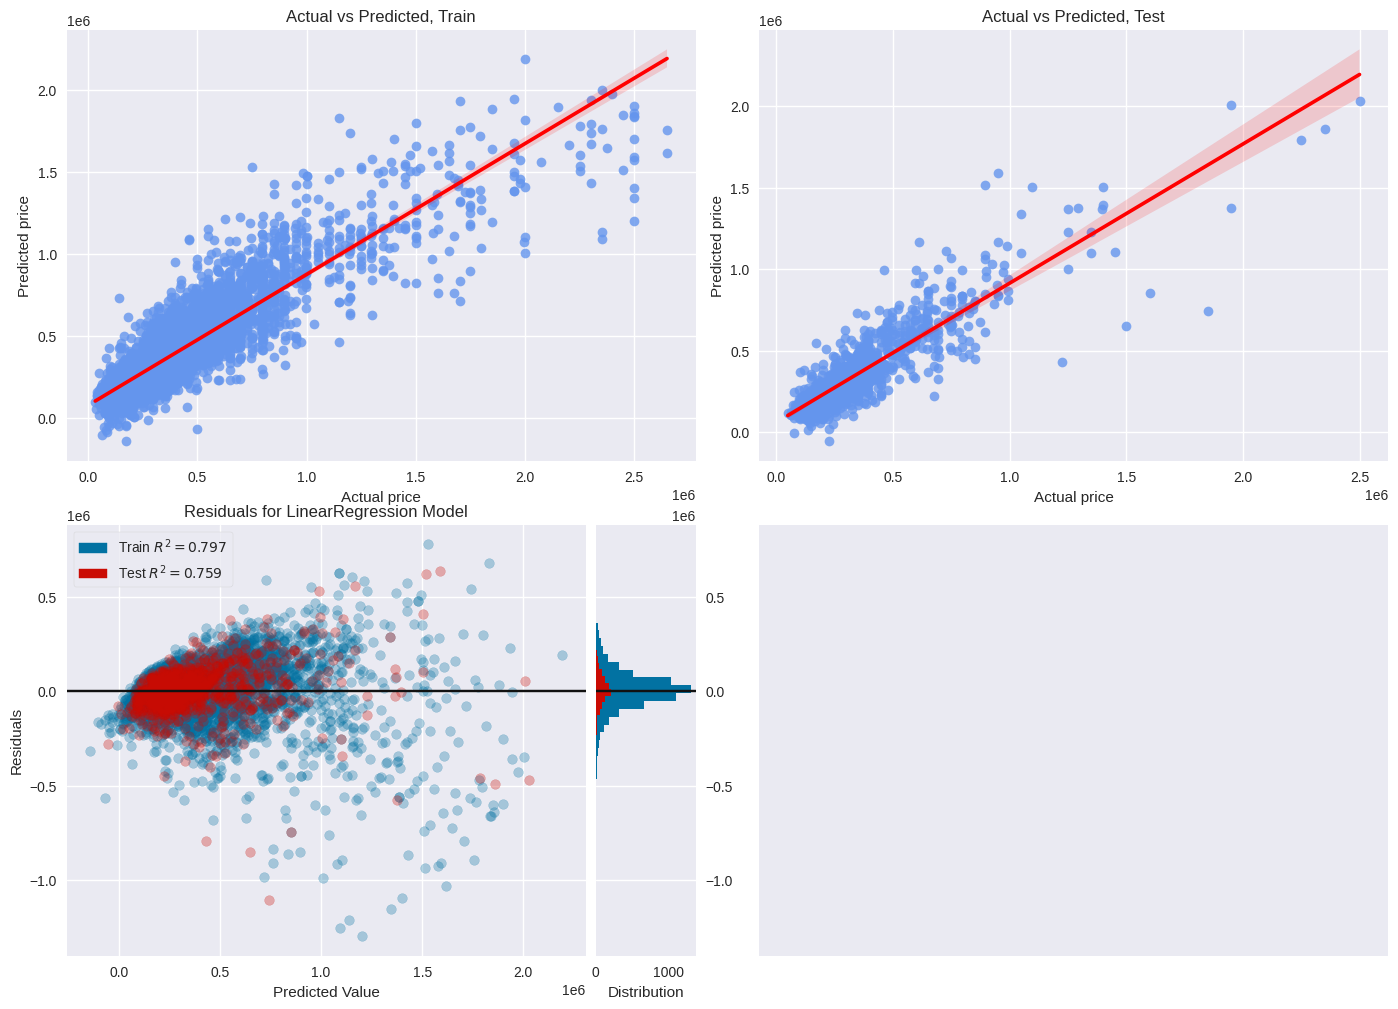

In [23]:
residuals(poly_pipe_estimator, X_train, X_test, y_train, y_test) 

**Conclusions**

- The model still predices a few negative values.
- The model doesn't predice well the price of expensive houses. It also tends to understimate the value of expensive houses but is better than the linear regression.
- We can consider that there is not overfitting.

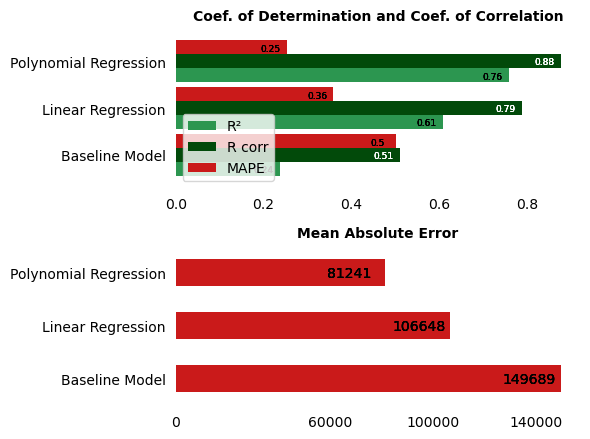

In [24]:
plot_metrics(metrics_to_plot)

The polynomial regression with degree four is even better than the linear regression. 

In [25]:
comp_met(metrics_to_plot, 'Polynomial Regression', 'Linear Regression')

Improvement respect Baseline Model: 68448€ -> 46%
Improvement respect Last Best Model: 25407€ -> 24%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|68,448€|25,407€|
|46%|24%|

## K-Nearest Neighbors Regressor

When apply the K-Nearest Neighbors Regressor the prediction is made based on the mean of its nearest neighbors. Bellow I use a `GridSearchCV` to find the best hyperparameters. 

In [26]:
knnr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            regressor=KNeighborsRegressor(),
                                            levels_list=[levels_place, levels_type_house],
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

param_grid = [{
        'preprocessor__num__poly__degree': [1,3],
        'regressor__n_neighbors': [7],  
        'regressor__weights': ['uniform', 'distance'],
        'regressor__leaf_size': [30]
             }]

grid_search = GridSearchCV(estimator=knnr_pipe_estimator, 
                           param_grid=param_grid,
                           cv=3, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'preprocessor__num__poly__degree': 1, 'regressor__leaf_size': 30, 'regressor__n_neighbors': 7, 'regressor__weights': 'distance'}
0.7547665305603588


In [27]:
# I use weights = 'uniform' instead of 'distance' to reduce overfitting
knnr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            regressor=KNeighborsRegressor(n_neighbors=7,
                                                                          weights='uniform', 
                                                                          leaf_size= 30), 
                                            levels_list=[levels_place, levels_type_house],
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores, scores_resume = scores_statistics(estimator=knnr_pipe_estimator, 
                                          scoring_dict=scoring, 
                                          X_train=X_train, 
                                          y_train=y_train, 
                                          cv=5, 
                                          return_train_score=False, 
                                          return_est=True)

r2 mean: 0.7395196974354233
r2 std: 0.016654307798403017 

MAE mean: -90084.9840678037
MAE std: 2690.9787385692184 

MAPE mean: -0.24768038753542349
MAPE std: 0.0077573151026093965 

RMSE mean: -154678.94843571965
RMSE std: 8960.714178182843 



### Overfitting Analysis

In [28]:
knnr = knnr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = knnr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = knnr.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['K-Nearest Neighbors'] = metrics

Performance on the training set:
 ----------
R²: 0.813909492892464
MAE: 76046.11665217191
MAPE: 0.2085554753434216
RMSE: 131159.52217378622
R (corr): 0.9026367241958279

Performance on the test set:
 ----------
R²: 0.7354667799127486
MAE: 79403.06637282862
MAPE: 0.22902629397052057
RMSE: 131163.58859948494
R (corr): 0.8577381578729018



The difference between performance in the training set is similar to the test set is a MAE of 3,000€ so it is okay in my opinion.

### Residuals Diagnostic

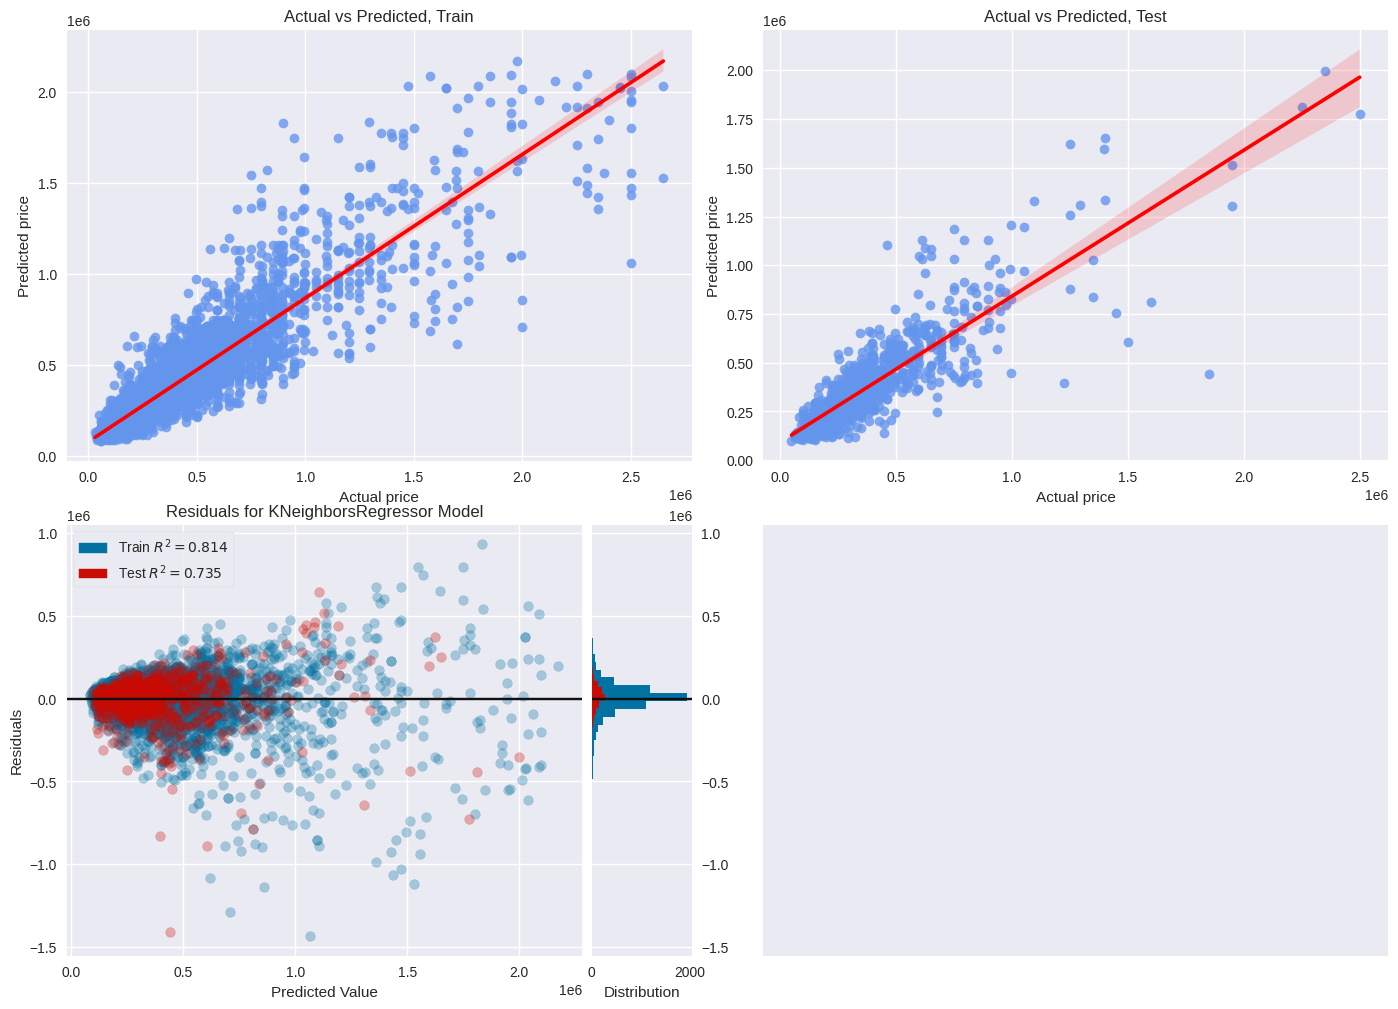

In [29]:
residuals(knnr_pipe_estimator, X_train, X_test, y_train, y_test)

**Conclusions**

- This time we don't have negative values!
- The model is not very good predicing prices of houses with actual prices above a million, but there is no so clear tendency to understimate them as in the previous models, but there it is.
- There is a litle bit more overfitting than in the previous one but is not too much. It is okay in my opinion.

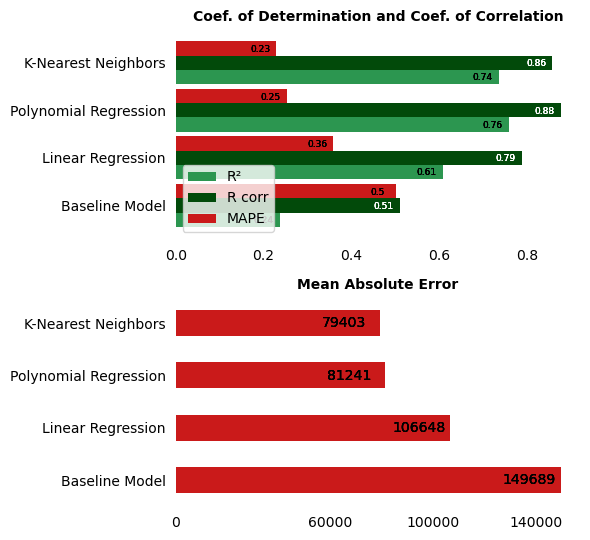

In [30]:
plot_metrics(metrics_to_plot)

In [31]:
comp_met(metrics_to_plot, 'K-Nearest Neighbors', 'Polynomial Regression')

Improvement respect Baseline Model: 70286€ -> 47%
Improvement respect Last Best Model: 1838€ -> 2%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|70,286€|1,838€|
|47%|2%|

## Decision Tree Regressor

In [32]:
dtr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=DecisionTreeRegressor(),
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

grid_search = GridSearchCV(estimator=dtr_pipe_estimator, 
                           param_grid={
                               'preprocessor__num__poly__degree': [1,3], #[1,2,3,4],
                               'regressor__max_depth': [10,11,12,13,14,15,16,17], #range(5, 15), #[2,3,4,5,6,7]
                               'regressor__min_samples_leaf': [10,11,12,13,14,15, 20, 25, 30], #[1, 3, 5, 10, 20, 50]
                   #            'regressor__min_samples_split': range(35, 45), #[2, 43],
                      #         'regressor__max_leaf_nodes': range(65, 75),
                         #      'regressor__max_features':,
                           }, 
                           cv=5, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)


{'preprocessor__num__poly__degree': 1, 'regressor__max_depth': 12, 'regressor__min_samples_leaf': 25}
0.7419698147645398


In [33]:
#pd.DataFrame(grid_search.cv_results_)

In [34]:
dtr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=DecisionTreeRegressor(max_depth=10,
                                                                           min_samples_leaf=30,  #16
                                                                       #   min_samples_split=43,
                                                                        #  max_leaf_nodes=68, 
                                                                           random_state=7),
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=3,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores = scores_statistics(estimator=dtr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7244271754387206
r2 std: 0.016444122884305967 

MAE mean: -95720.65620385474
MAE std: 3030.3294388933214 

MAPE mean: -0.2712017258315317
MAPE std: 0.00871030257995838 

RMSE mean: -159154.62550374036
RMSE std: 9832.327135171457 



In [35]:
# dtr_pipe_estimator

### Overfitting Analysis

In [36]:
dtr = dtr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = dtr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = dtr.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Decision Tree Regressor'] = metrics

Performance on the training set:
 ----------
R²: 0.7796071905921366
MAE: 83858.88782988206
MAPE: 0.23745635880920332
RMSE: 142736.95464148003
R (corr): 0.8829536740917592

Performance on the test set:
 ----------
R²: 0.7152036847576781
MAE: 83653.67766455417
MAPE: 0.2464408266449944
RMSE: 136094.43410211886
R (corr): 0.8484570979479041



In [37]:
# dtr

The different in MAE is insignificant so there is no overfitting. I have changed the parameter values to regularize a little the model as the different in the metrics was bigger earlier. That is why the parameters are different that the GridSearchCV ones.

[feature importances](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.feature_importances_)

In [107]:
# dtr.steps[1][1].feature_importances_

### Residuals Diagnostic

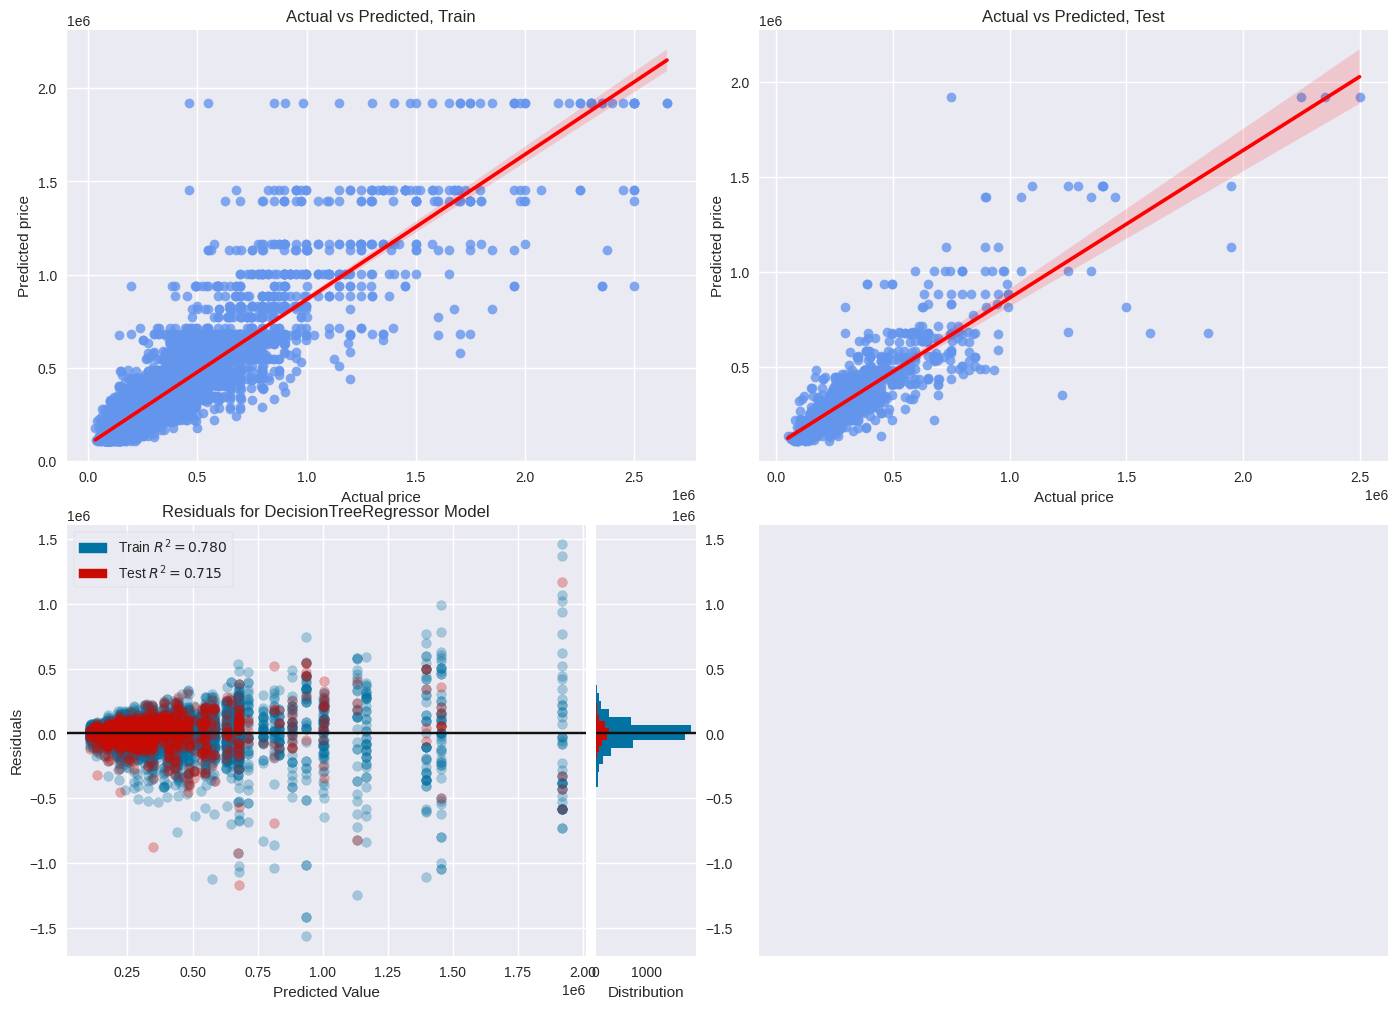

In [38]:
residuals(dtr_pipe_estimator, X_train, X_test, y_train, y_test)

**Conclusions**
- The model appears to be pretty accurate in values less than 1 million € but the errors increase a lot as the actual price increases as well.
- There is a tendency to understimate values and it is clearer in houses with high values. However, some values with very high actual prices are overstimated as can be observed in the first and third graphs. They can be seen in the horizontal lines in the first graph or in the horizontal ones in the thikrd graph. Overstimated values are very dangerous for us, more than the understimated values because overstimated values could encourage us to invest money being the actual value of the asset lower.
- There is no overfitting.

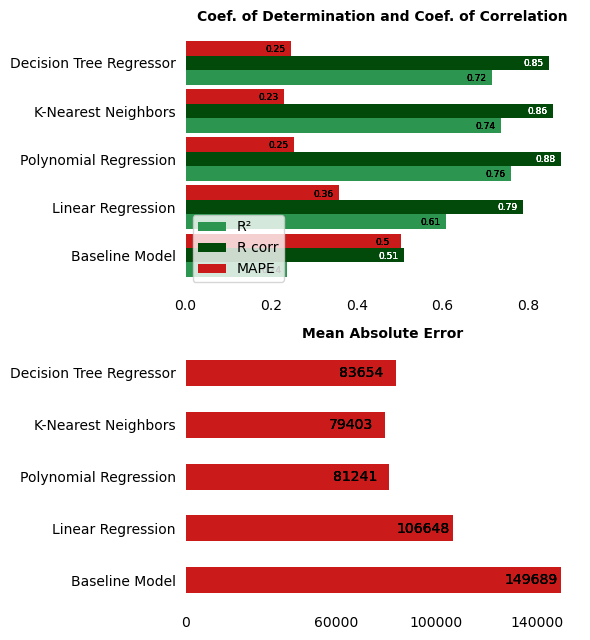

In [39]:
plot_metrics(metrics_to_plot)

In [86]:
comp_met(metrics_to_plot, 'Decision Tree Regressor', 'K-Nearest Neighbors')

Improvement respect Baseline Model: 66036€ -> 44%
Improvement respect Last Best Model: -4251€ -> -5%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|66,036€|-4,251€|
|44%|-5%|

## Voting Regressor with Basic Algorithms

I think it is interesting to investigate how the basic algorithms we used above can perform together. So let's do a voting regresor with them to figure out that.

In [97]:
scoring_comp = {'r2': 'r2',
                'MAE': 'neg_mean_absolute_error'}

Calculate the weights: we will use the performance in the test set to calculate the weights.

In [98]:
scores_dict = {}
scores_dict['Polynomial Regression'] = metrics_to_plot['Polynomial Regression'][0]
scores_dict['K-Nearest Neighbors'] = metrics_to_plot['K-Nearest Neighbors'][0]
scores_dict['Decision Tree Regressor'] = metrics_to_plot['Decision Tree Regressor'][0]


models_weigth_list = get_weigts(scores_dict=scores_dict)

{'Polynomial Regression': 0.7592090096144875, 'K-Nearest Neighbors': 0.7354667799127486, 'Decision Tree Regressor': 0.7152036847576781}


In [99]:
polyr = poly_pipe_estimator
knnr = knnr_pipe_estimator
dtr = dtr_pipe_estimator


voting_regressor_BA = VotingRegressor(
    estimators = [('poly', polyr),
                  ('knn', knnr),
                  ('dt', dtr)], 
    weights = models_weigth_list)

models_dict = {'Polynomial Regression': poly_pipe_estimator, 
               'K Nearest Neighbors Regressor': knnr_pipe_estimator, 
               'Decission Tree Regressor': dtr_pipe_estimator, 
               'Voting Regressor': voting_regressor_BA}
# Comparing with corss validation
for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=5, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7638349740456015
MAE mean: -92225.37212199638
MAPE mean: -0.26962644120542917
RMSE mean: -147198.85906626005
----------
K Nearest Neighbors Regressor
r2 mean: 0.7395196974354233
MAE mean: -90084.9840678037
MAPE mean: -0.24768038753542349
RMSE mean: -154678.94843571965
----------
Decission Tree Regressor
r2 mean: 0.7244271754387206
MAE mean: -95720.65620385474
MAPE mean: -0.2712017258315317
RMSE mean: -159154.62550374036
----------
Voting Regressor
r2 mean: 0.7911792812273355
MAE mean: -82114.18959488028
MAPE mean: -0.23029939768438093
RMSE mean: -138643.00504352723
----------


Cool! We have been able to improve the performance with the voting regressor. Next we will do the overfitting analysis and the residuals diagnostic before start making more complex models. 

### Overfitting Analysis

In [43]:
voting_regressor_BA.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor_BA.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor_BA.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Voting Regressor BA'] = metrics

Performance on the training set:
 ----------
R²: 0.8353074491026161
MAE: 72518.17755583831
MAPE: 0.2036890355632705
RMSE: 123388.50273909702
R (corr): 0.9155274670067198

Performance on the test set:
 ----------
R²: 0.7943794715496575
MAE: 70992.84824821287
MAPE: 0.21294937096532413
RMSE: 115639.55627813538
R (corr): 0.8913812602271166



The different in MAE is less than 2,000€ so we will consider there is no overfitting.

### Residuals Diagnostic

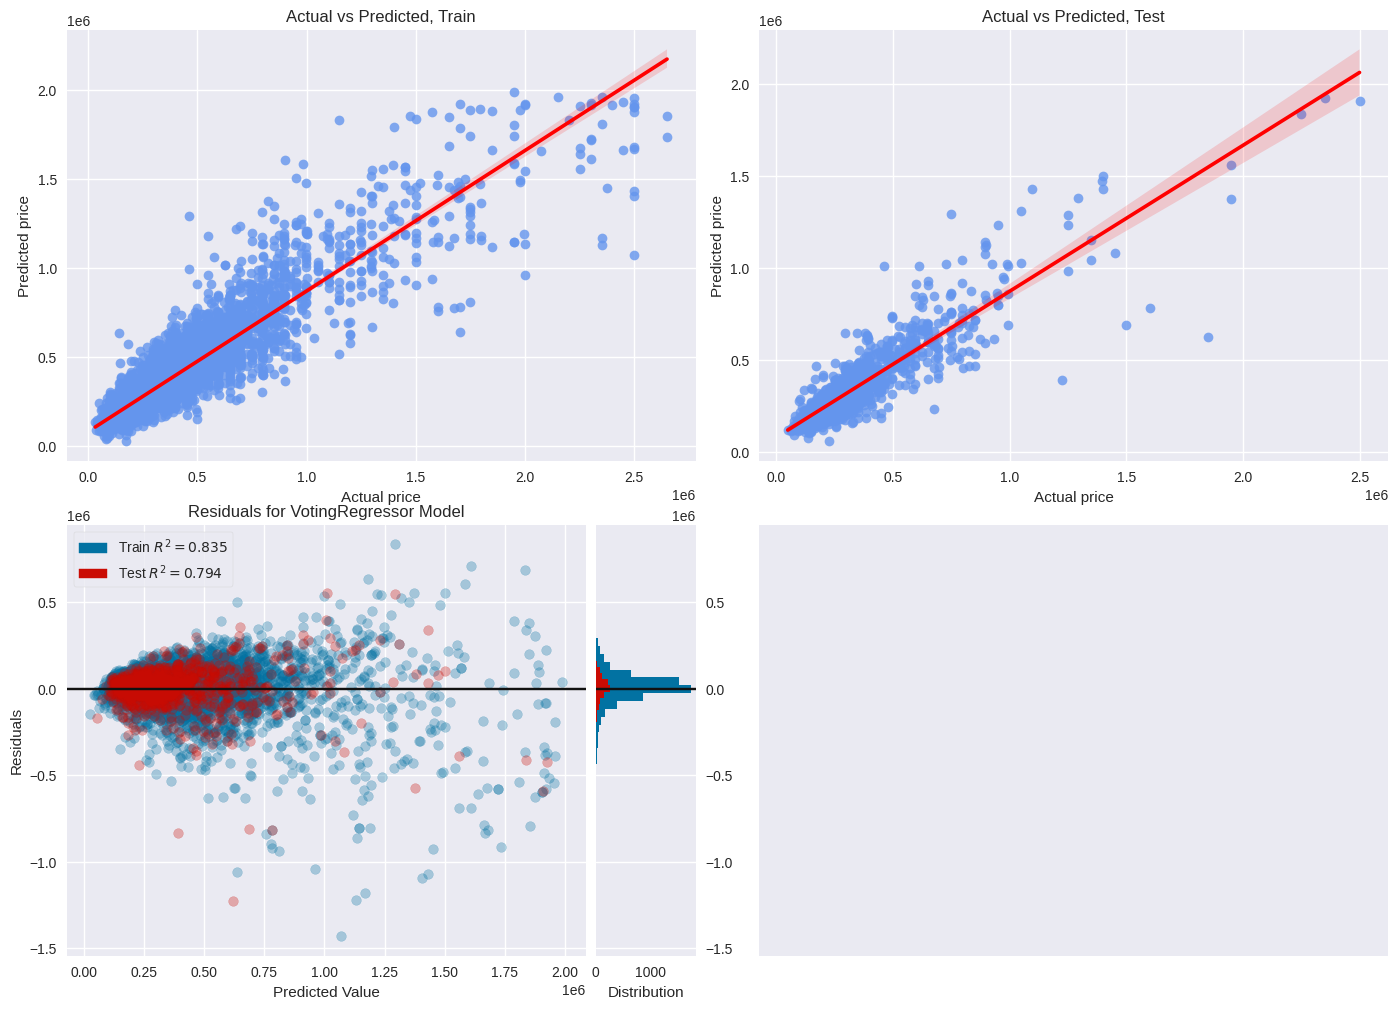

In [44]:
residuals(voting_regressor_BA, X_train, X_test, y_train, y_test)

**Conclusions**
- The voting regressor is clearly better than the models separately.  
- Once again we can realise that houses which actual price is higher than 1 million € are generally worst predicted than the other ones.
- There is a clear tendency to understimate prices as the actual prices increase. This is normal as the models that make up the voting regressor suffer the same condition.

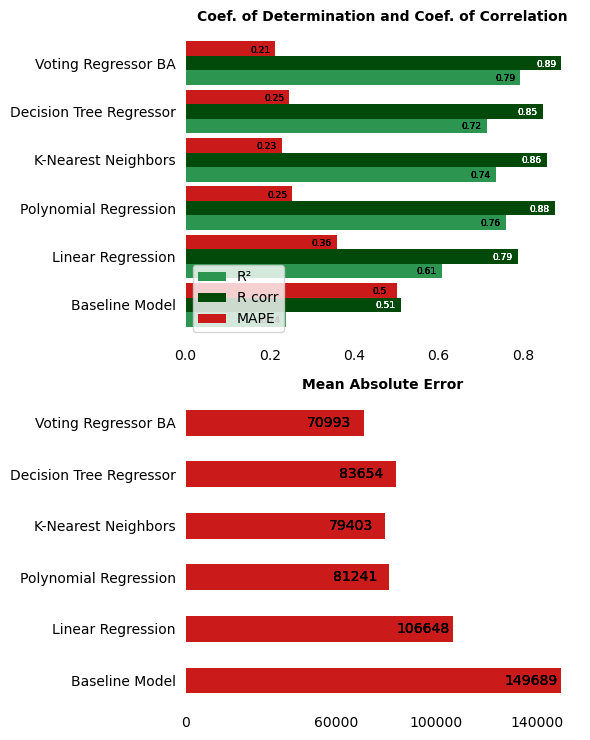

In [45]:
plot_metrics(metrics_to_plot)

In [87]:
comp_met(metrics_to_plot, 'Voting Regressor BA', 'K-Nearest Neighbors')

Improvement respect Baseline Model: 78696€ -> 53%
Improvement respect Last Best Model: 8410€ -> 11%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|78,696€|8,410€|
|53%|11%|

## Random Forest Regressor

The random forest regressor cells have been runned iteratively several times in order to find the best combination of hyperparameters that maximize the performance while overfitting is under control.

/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


Valor óptimo de n_estimators: 41


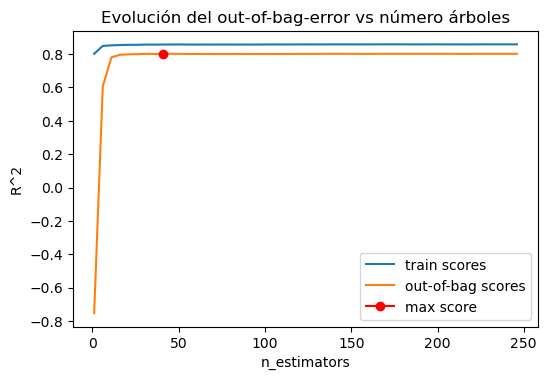

In [46]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 250, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    rfr = transformer_estimator(num_transformation='identity', 
                                regressor=RandomForestRegressor(
                                    n_estimators=n_estimators,
                                    max_depth=10,
                                    min_samples_leaf=9,  
                                    random_state=7,
                                    bootstrap=True,
                                    n_jobs=-1,
                                    oob_score = True
                                ), 
                                levels_list=[levels_place, levels_type_house],
                                poly_degree=1,
                                num_feat=num_features,
                                cat_feat=cat_features)

    
    rfr.fit(X_train, y_train)
    train_scores.append(rfr.score(X_train, y_train))
    oob_scores.append(rfr.steps[-1][1].oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

In [47]:
from sklearn.model_selection import RandomizedSearchCV


# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [41, 60, 100],
          #       'max_features': range(2, 20, 2), # ['log2', 'sqrt'],
                 'max_depth'   : [None, 3, 10, 20],
           #      'min_samples_split': [2, 5, 8, 15, 20, 43],  # 43
                 'min_samples_leaf': [1, 3, 5, 10, 20, 50],   #16
            #       'max_leaf_nodes': [2, 4, 8, 13, 20, 30, 40, 60, 80],   #68
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = transformer_estimator(num_transformation='identity', 
                                   regressor=RandomForestRegressor(
                              #         n_estimators=n_estimators,
                               #        max_depth=10,
                                #       min_samples_leaf=9,  
                                       random_state=7,
                                       bootstrap=True,
                                       n_jobs=-1,
                                       oob_score = True, 
                                       ** params
                                   ), 
                                   levels_list=[levels_place, levels_type_house],
                                   poly_degree=1,
                                   num_feat=num_features,
                                   cat_feat=cat_features)
    
    

    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.steps[-1][1].oob_score_)
    #print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

,oob_r2,max_depth,min_samples_leaf,n_estimators
56,0.818203,20.0,1.0,100.0
2,0.817661,NaN,1.0,100.0
59,0.817458,20.0,3.0,100.0
5,0.817411,NaN,3.0,100.0


Despite the results obtained above if we are so little restrictive with the model and we allow it to have too many degrees of freedom the model will overffit the training data. So I have decided to restrict the model throught some hyperparameters in order to avoid it.

In [48]:
rfr = transformer_estimator(num_transformation='identity', 
                            regressor=RandomForestRegressor(
                                n_estimators=41,    #41
                                max_depth=10,
                                min_samples_leaf=9,  
                                random_state=7,
                                bootstrap=True,
                                n_jobs=-1,
                                oob_score = True 
                            ), 
                            levels_list=[levels_place, levels_type_house],
                            poly_degree=1,
                            num_feat=num_features,
                            cat_feat=cat_features)
    
rfr.fit(X_train, y_train)
print('Train score:', rfr.score(X_train, y_train))
print('Out-of-bag score', rfr.steps[-1][1].oob_score_)

Train score: 0.8575707805056108
Out-of-bag score 0.8023788760201988


#### As the other models

In [49]:
rfr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=RandomForestRegressor(
                                               n_estimators=180, 
                                               max_depth=10,
                                               min_samples_leaf=9,  
                                               random_state=7,
                                               bootstrap=True,
                                               n_jobs=-1), 
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores = scores_statistics(estimator=rfr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7948128257083071
r2 std: 0.01803789033047241 

MAE mean: -80470.39412116422
MAE std: 2935.847477489869 

MAPE mean: -0.23063634829650095
MAPE std: 0.007611134757614636 

RMSE mean: -137273.0266374894
RMSE std: 9675.5830929408 



In [50]:
rfr = rfr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = rfr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = rfr.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Random Forest Regressor'] = metrics

Performance on the training set:
 ----------
R²: 0.858628578389867
MAE: 67358.35608885474
MAPE: 0.1976212605063636
RMSE: 114319.02946191106
R (corr): 0.9276415056759836

Performance on the test set:
 ----------
R²: 0.7771864260758329
MAE: 71761.09109968114
MAPE: 0.2158772126311052
RMSE: 120377.13518010032
R (corr): 0.8830538464667295



The different between MAE is less than 5,000€ which is okay.

### Feature Importances

Now let's investigate a little the feature importances to see if it can be obtained some useful insighs.

In [132]:
# Number of features importances
len(rfr.steps[1][1].feature_importances_)

145

There are 145 feature importances, which correspond to the 145 features there are after the transformations of the categorical data plus the numerica features.

In [135]:
feat_df

,numerical,categorical
0,floor_area,place
1,bedroom,type_house
2,bathroom,
3,longitude,
4,latitude,


In [134]:
cat_feat_df

,categorical,n_levels,sample
0,place,137,"[Naas, Wexford, Dublin 8, Dublin 6W, Carrick o..."
1,type_house,3,"[house, apartment, Unknown]"


In [137]:
# Numeric features + `place` levels + `type_house` levels
5 + 137 + 3

145

If we wanted to get the features that the random forest was fed we would need to transform the train set before.

In [138]:
estimator_to_get_features = transformer_estimator(num_transformation='identity',  
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=1,
                                           num_feat=num_features,
                                           cat_feat=cat_features)

X_train_tr = estimator_to_get_features.fit_transform(X_train)
X_train_tr.shape

(6242, 145)

In [139]:
X_train_tr.toarray()

array([[135.,   3.,   2., ...,   1.,   0.,   0.],
       [ 70.,   2.,   1., ...,   1.,   0.,   0.],
       [182.,   4.,   3., ...,   1.,   0.,   0.],
       ...,
       [ 95.,   3.,   1., ...,   0.,   0.,   1.],
       [ 51.,   2.,   1., ...,   1.,   0.,   0.],
       [ 70.,   2.,   1., ...,   1.,   0.,   0.]])

The above data was given to the algorithm, and if we compare it with the train set bello we can see that the columns are the same except because above there are 140 columns filled with 0 and 1 instead the tow columns corresponding to `type_house` and `place`.

In [123]:
X_train.head()

,floor_area,latitude,longitude,bedroom,bathroom,type_house,place
5631,135,52.925490,-6.791318,3,2,house,Naas
4768,70,51.861624,-8.252959,2,1,house,Cobh
5862,182,52.626521,-7.218027,4,3,house,Kilkenny
1538,143,51.972982,-8.216473,4,3,house,Fermoy
2368,185,53.699557,-6.260619,4,3,house,Drogheda


It easier to see the importance of the numeric features as they are still in a column but the categorical features are distributed in lots of columns. [feature_importances scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.feature_importances_)

My only idea for now is to add al the scores for the columns corresponding to both categorical columns and see what is the score obtained. As the first five scores belong to the numeric features we can add the rest ones.

In [140]:
sum(rfr.steps[1][1].feature_importances_[5:])

0.01504050422844815

And finally it would be interisting to plot the numeric features importance scores.

In [145]:
# Numeric columns
X_train.columns[:5]

Index(['floor_area', 'latitude', 'longitude', 'bedroom', 'bathroom'], dtype='object')

In [127]:
# Numeric columns feature importances
rfr.steps[1][1].feature_importances_[:5]

array([0.44640124, 0.00283604, 0.00507873, 0.38583079, 0.1448127 ])

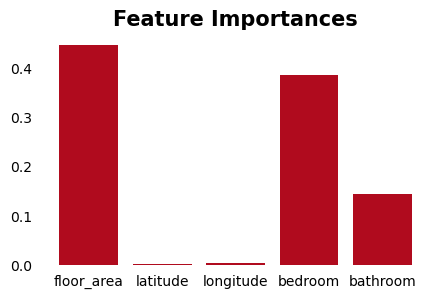

In [155]:
fig, ax = plt.subplots(figsize=(5,3))


plt.bar(X_train.columns[:5], rfr.steps[1][1].feature_importances_[:5], 
            color='#b00b1e')

ax.set_title('Feature Importances', weight='bold', size=15)
ax.tick_params(bottom=False, left=False)
ax.set_xlabel('')
for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)

### Residuals Diagnostic

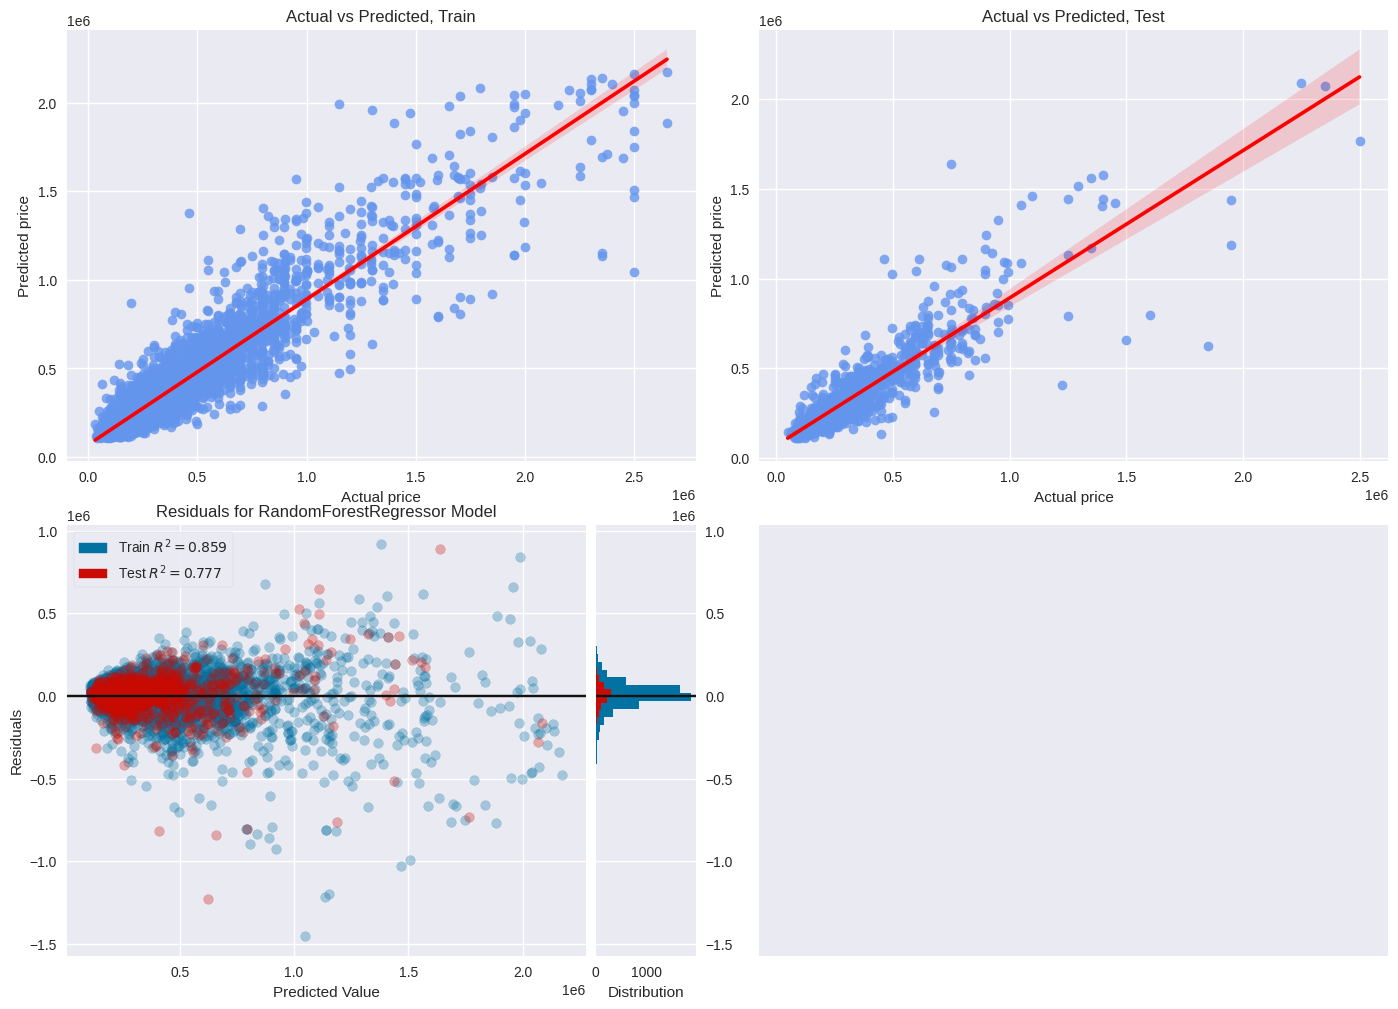

In [51]:
residuals(rfr, X_train, X_test, y_train, y_test)

**Conclusions**
- The tendency to understimate high values is a little smoother in the random forest.
- The model's performance is better predicting houses prices cheapper than a million euros than highers as well. 
- The voting regressor is still better than the random forest.

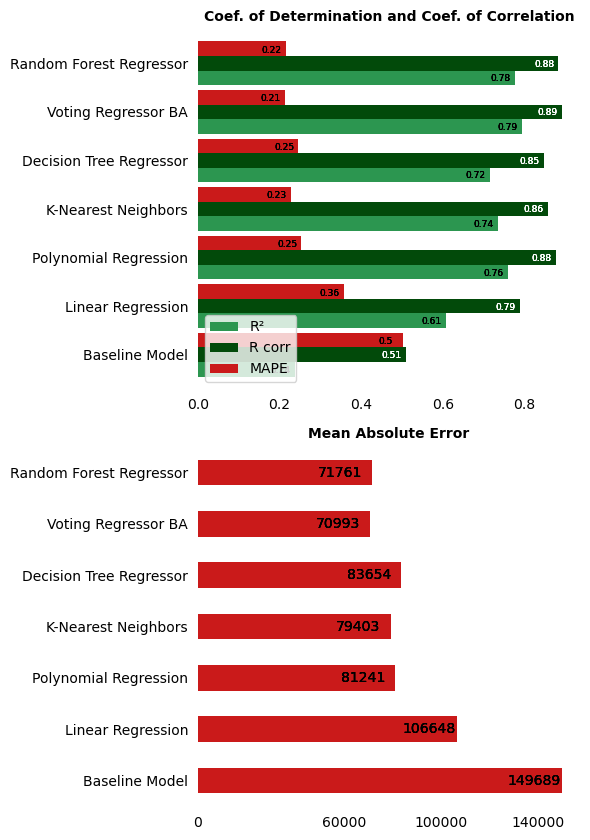

In [52]:
plot_metrics(metrics_to_plot)

In [88]:
comp_met(metrics_to_plot, 'Random Forest Regressor', 'Voting Regressor BA')

Improvement respect Baseline Model: 77928€ -> 52%
Improvement respect Last Best Model: -768€ -> -1%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|77,928€|-768€|
|52%|-1%|

## Extreme Gradient Boosting

The next code will give us the RMSE in the traiing set and in the test set 300 times, adding a new estimator every time. This will help us to choose the optimum number of estimators.

In [53]:
pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=1,
                                           num_feat=num_features,
                                           cat_feat=cat_features,
                                           regressor=None)


df = data.copy()
y2 = df['price']
X2 = df.drop(columns='price')

X2 = pipe_estimator.fit_transform(X2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=.15,
                                                        random_state=7)

xgb2 = XGBRegressor(n_estimators= 300, 
                    max_depth=3,
                    learning_rate=.1,
                    subsample=.25)
   
xgb2.fit(X_train2, y_train2,
         eval_set=[(X_train2, y_train2), (X_test2, y_test2)],
        # early_stopping_rounds=50
        )

[0]	validation_0-rmse:453858.46875	validation_1-rmse:407035.78125
[1]	validation_0-rmse:417879.40625	validation_1-rmse:373322.34375
[2]	validation_0-rmse:385127.96875	validation_1-rmse:341416.40625
[3]	validation_0-rmse:355672.06250	validation_1-rmse:313810.03125
[4]	validation_0-rmse:330057.06250	validation_1-rmse:289391.81250
[5]	validation_0-rmse:306698.06250	validation_1-rmse:267665.34375
[6]	validation_0-rmse:286240.09375	validation_1-rmse:248507.42188
[7]	validation_0-rmse:268081.65625	validation_1-rmse:231536.37500
[8]	validation_0-rmse:251999.42188	validation_1-rmse:216863.78125
[9]	validation_0-rmse:238583.01562	validation_1-rmse:205219.39062
[10]	validation_0-rmse:226892.06250	validation_1-rmse:194319.60938
[11]	validation_0-rmse:216022.96875	validation_1-rmse:184938.79688
[12]	validation_0-rmse:207429.68750	validation_1-rmse:177333.15625
[13]	validation_0-rmse:198748.17188	validation_1-rmse:170024.84375
[14]	validation_0-rmse:191730.01562	validation_1-rmse:163887.79688
[15]	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.25,
             tree_method='exact', validate_parameters=1, verbosity=None)

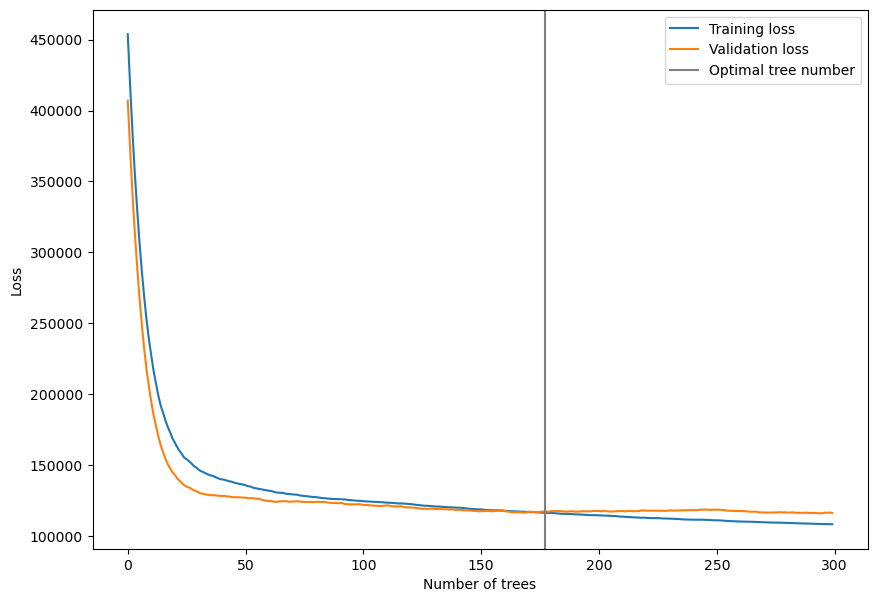

In [54]:
results = xgb2.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(177, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend();

Once we know the optimum number of estimators we can obtain the metrics of our model. After a few iterations I realise that a `max_depth` of 3 helps us reduce overfitting.

In [55]:
xgb_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=XGBRegressor(
                                               n_estimators= 177, #150
                                               max_depth=3,
                                               learning_rate=.1,
                                               subsample=.30),
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores = scores_statistics(estimator=xgb_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.8010601674838664
r2 std: 0.0342964497397751 

MAE mean: -82504.58731766627
MAE std: 4462.988489004097 

MAPE mean: -0.2382942345142208
MAPE std: 0.010066193385428655 

RMSE mean: -134497.96853927473
RMSE std: 12259.275600604658 



### Overfitting Analysis

In [56]:
xgb = xgb_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = xgb.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = xgb.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['XGB'] = metrics

Performance on the training set:
 ----------
R²: 0.8576285038595663
MAE: 74929.64309691405
MAPE: 0.2243544160945845
RMSE: 114722.6685761221
R (corr): 0.9265220477790842

Performance on the test set:
 ----------
R²: 0.7890097100558853
MAE: 73284.15001134301
MAPE: 0.22314703160746896
RMSE: 117139.78310464171
R (corr): 0.8894082849975257



### Residuals Diagnostic

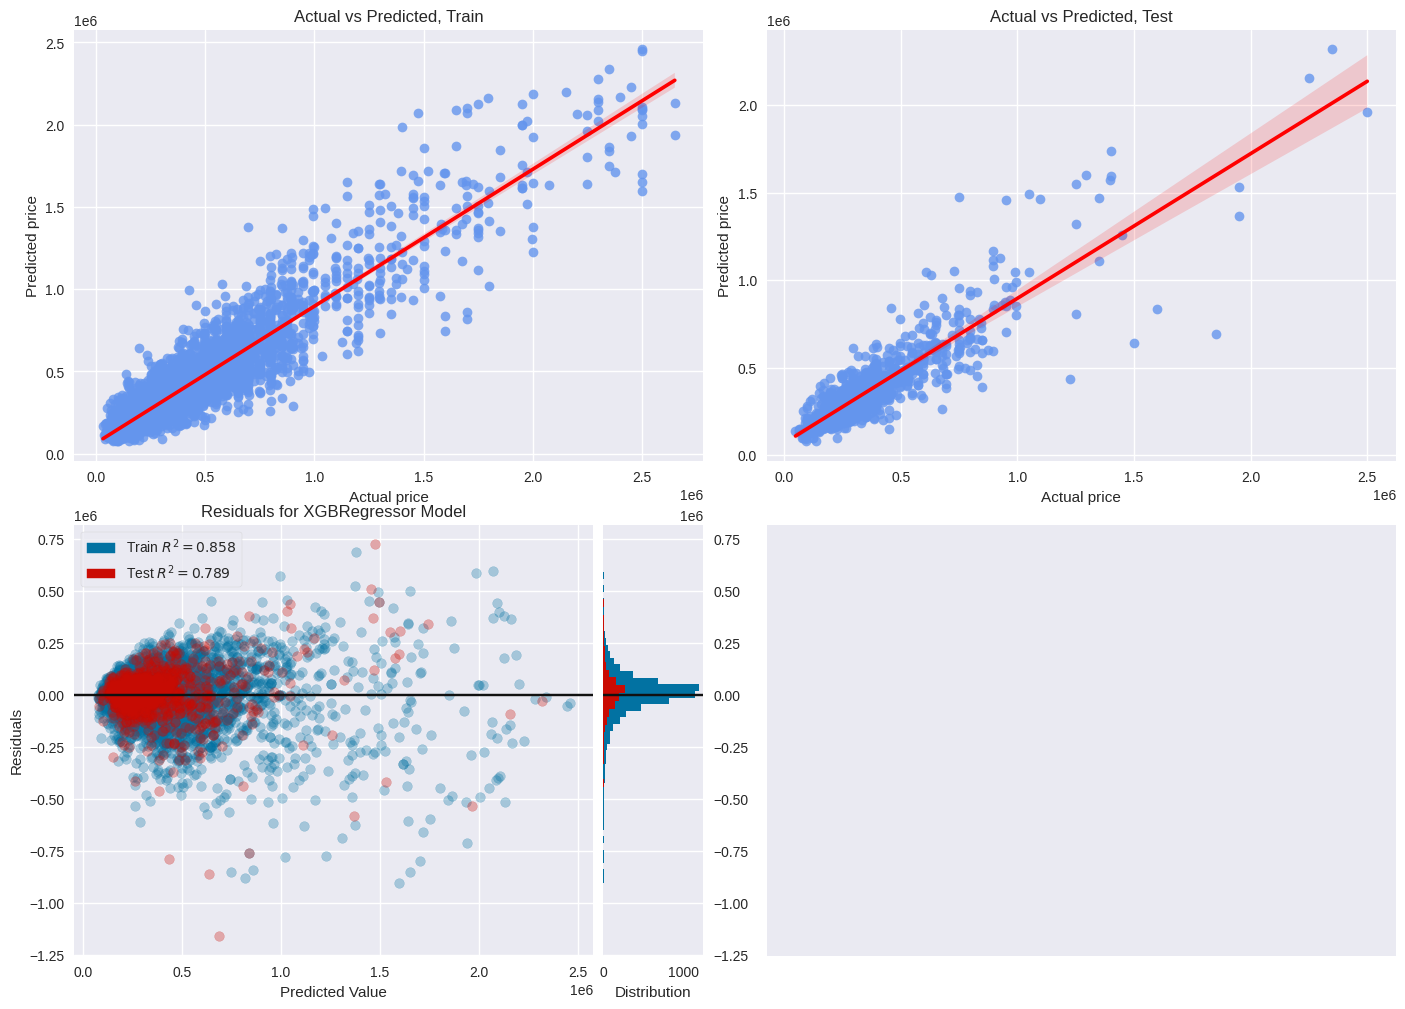

In [57]:
residuals(xgb_pipe_estimator, X_train, X_test, y_train, y_test)

**Conclusions**
- The XGBRegressor appears to be a little bit better than the Random Forest.
- Following the same line as the previous models, the model's performance is better predicting houses prices cheapper than a million euros than highers as well.
- The tendency to understimate high values is still there.
- Both XGBRegressor and Voting Regressor with Basic Algorithms.

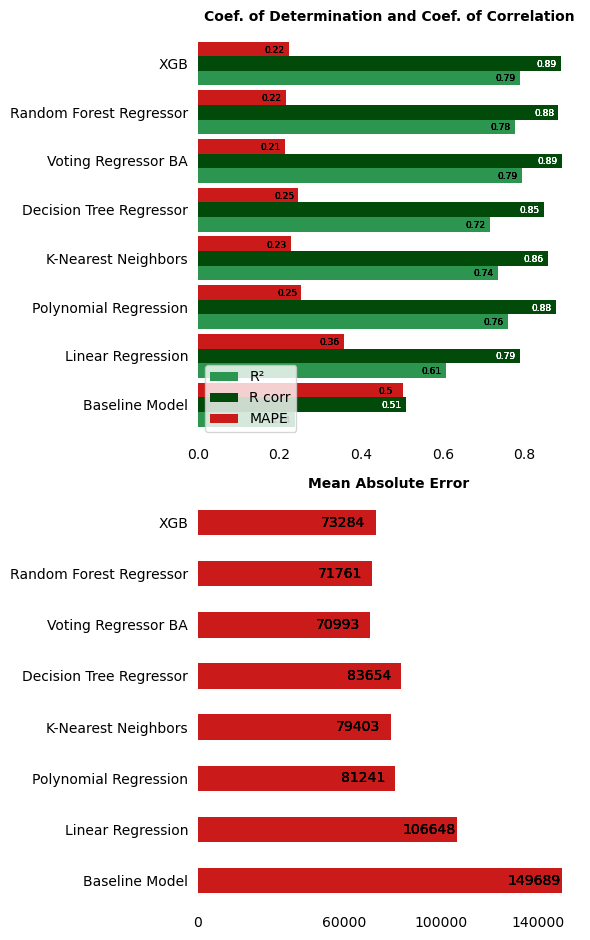

In [58]:
plot_metrics(metrics_to_plot)

In [89]:
comp_met(metrics_to_plot, 'XGB', 'Voting Regressor BA')

Improvement respect Baseline Model: 76405€ -> 51%
Improvement respect Last Best Model: -2291€ -> -3%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|76,405€|-2,291€|
|51%|-3%|

## Voting Regressor with Ensemble Methods

Now let's see some combinations of voting regressors to see their performance.

The voting regressor that is performing better is the second, made up of:
- Voting Regressor Basic Algorithms
- Random Forest
- Extreme Gradient Boosting

So we will focus on it before try all voting regressors.

### Voting Regressor 1: poly + rfr + xgb

In [100]:
scores_dict = {}
scores_dict['Polynomial Regression'] = metrics_to_plot['Polynomial Regression'][0]
scores_dict['Random Forest Regressor'] = metrics_to_plot['Random Forest Regressor'][0]
scores_dict['XGB'] = metrics_to_plot['XGB'][0]

models_weigth_list = get_weigts(scores_dict=scores_dict)

{'Polynomial Regression': 0.7592090096144875, 'Random Forest Regressor': 0.7771864260758329, 'XGB': 0.7890097100558853}


In [101]:
polyr = poly_pipe_estimator
# rfr = rfr
egb = xgb_pipe_estimator

voting_regressor1 = VotingRegressor(
    estimators= [('poly', polyr),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor1}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=5, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7638349740456015
MAE mean: -92225.37212199638
----------
Random Forest Regressor
r2 mean: 0.7948128257083071
MAE mean: -80470.39412116422
----------
XGBoost
r2 mean: 0.802591204267571
MAE mean: -82641.11066096167
----------
Voting Regressor
r2 mean: 0.8111459079058454
MAE mean: -79124.65345323649
----------


In [61]:
voting_regressor1.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor1.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor1.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8576086440468393
MAE: 70939.58606662367
MAPE: 0.20606879846440526
RMSE: 114730.66979591202
R (corr): 0.9272291695601719

Performance on the test set:
 ----------
R²: 0.8019826749510937
MAE: 69790.42682133375
MAPE: 0.2127306283099896
RMSE: 113481.42373896379
R (corr): 0.896457050312054



(0.8019826749510937, 69790.42682133375, 0.896457050312054, 0.2127306283099896)

### Voting Regressor 2: voting_regressor_BA + rfr + xgb 

In [62]:
scores_dict = {}
scores_dict['Voting Regressor BA'] = metrics_to_plot['Voting Regressor BA'][0]
scores_dict['Random Forest Regressor'] = metrics_to_plot['Random Forest Regressor'][0]
scores_dict['XGB'] = metrics_to_plot['XGB'][0]

models_weigth_list = get_weigts(scores_dict=scores_dict)

{'Voting Regressor BA': 0.7943794715496575, 'Random Forest Regressor': 0.7771864260758329, 'XGB': 0.7890097100558853}


In [63]:
# voting_regressor_BA = voting_regressor_BA
# rfr = rfr
egb = xgb_pipe_estimator

voting_regressor2 = VotingRegressor(
    estimators= [('voting_reg', voting_regressor_BA),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Voting Regressor BA': voting_regressor_BA, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor2}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=6, 
                            return_train_score=False)

Voting Regressor BA
r2 mean: -20427584955722.95
MAE mean: -17367993738.696774
----------
Random Forest Regressor
r2 mean: 0.7972481964811244
MAE mean: -80100.63331984098
----------
XGBoost
r2 mean: 0.7978100554688163
MAE mean: -83477.50222060627
----------
Voting Regressor
r2 mean: -2313328034383.5464
MAE mean: -5844717820.3093405
----------


In [64]:
voting_regressor2.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor2.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor2.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Voting Regressor 2'] = metrics

Performance on the training set:
 ----------
R²: 0.8620708656311066
MAE: 68795.01911103426
MAPE: 0.20049036288948965
RMSE: 112918.66148198469
R (corr): 0.9301237309211793

Performance on the test set:
 ----------
R²: 0.8012009051238831
MAE: 68950.64029392264
MAPE: 0.20938477364850186
RMSE: 113705.21466906737
R (corr): 0.8953917397738652



### Voting Regressor 3: rfr + xgb

In [65]:
scores_dict = {}
scores_dict['Random Forest Regressor'] = metrics_to_plot['Random Forest Regressor'][0]
scores_dict['XGB'] = metrics_to_plot['XGB'][0]


models_weigth_list = get_weigts(scores_dict=scores_dict)

{'Random Forest Regressor': 0.7771864260758329, 'XGB': 0.7890097100558853}


In [66]:
# polyr = poly_pipe_estimator
# rfr = rfr
egb = xgb_pipe_estimator

voting_regressor3 = VotingRegressor(
    estimators= [#('poly', polyr),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {#'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor3}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=6, 
                            return_train_score=False)

Random Forest Regressor
r2 mean: 0.7972481964811244
MAE mean: -80100.63331984098
----------
XGBoost
r2 mean: 0.7978100554688163
MAE mean: -83477.50222060627
----------
Voting Regressor
r2 mean: 0.8070675400422512
MAE mean: -79774.8284310832
----------


In [67]:
voting_regressor3.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor3.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor3.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8664188346787505
MAE: 69398.3342243469
MAPE: 0.20640303140943744
RMSE: 111124.63053378662
R (corr): 0.9319223644993948

Performance on the test set:
 ----------
R²: 0.7924245686782847
MAE: 70502.73747804061
MAPE: 0.21452990773094147
RMSE: 116187.96777376409
R (corr): 0.8910575135644901



(0.7924245686782847,
 70502.73747804061,
 0.8910575135644901,
 0.21452990773094147)

### Voting Regressor 4: voting_regressor_BA + rfr

In [68]:
scores_dict = {}
scores_dict['Voting Regressor BA'] = metrics_to_plot['Voting Regressor BA'][0]
scores_dict['Random Forest Regressor'] = metrics_to_plot['Random Forest Regressor'][0]

models_weigth_list = get_weigts(scores_dict=scores_dict)

{'Voting Regressor BA': 0.7943794715496575, 'Random Forest Regressor': 0.7771864260758329}


In [69]:
voting_regressor4 = VotingRegressor(
    estimators= [('voting_reg', voting_regressor_BA),
                 ('rf', rfr)], 
    weights= models_weigth_list,
)

models_dict = {'Voting Regressor BA': voting_regressor_BA, 
               'Random Forest Regressor': rfr,
               'Voting Regressor4': voting_regressor4}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=6, 
                            return_train_score=False)

Voting Regressor BA
r2 mean: -20427584955722.95
MAE mean: -17367993738.696774
----------
Random Forest Regressor
r2 mean: 0.7972481964811244
MAE mean: -80100.63331984098
----------
Voting Regressor4
r2 mean: -5219247097125.8125
MAE mean: -8779037788.448908
----------


In [70]:
voting_regressor4.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor4.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor4.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8543111983284635
MAE: 67872.37942179378
MAPE: 0.19443034010638413
RMSE: 116051.51162284122
R (corr): 0.9260693768019718

Performance on the test set:
 ----------
R²: 0.7968100967202919
MAE: 69022.51294346967
MAPE: 0.20830610356158097
RMSE: 114954.0410469177
R (corr): 0.8928980478197335



(0.7968100967202919,
 69022.51294346967,
 0.8928980478197335,
 0.20830610356158097)

### Residuals Diagnostic Voting Regressor 2: 

Let's get the diagnostic for the second voting regressor.

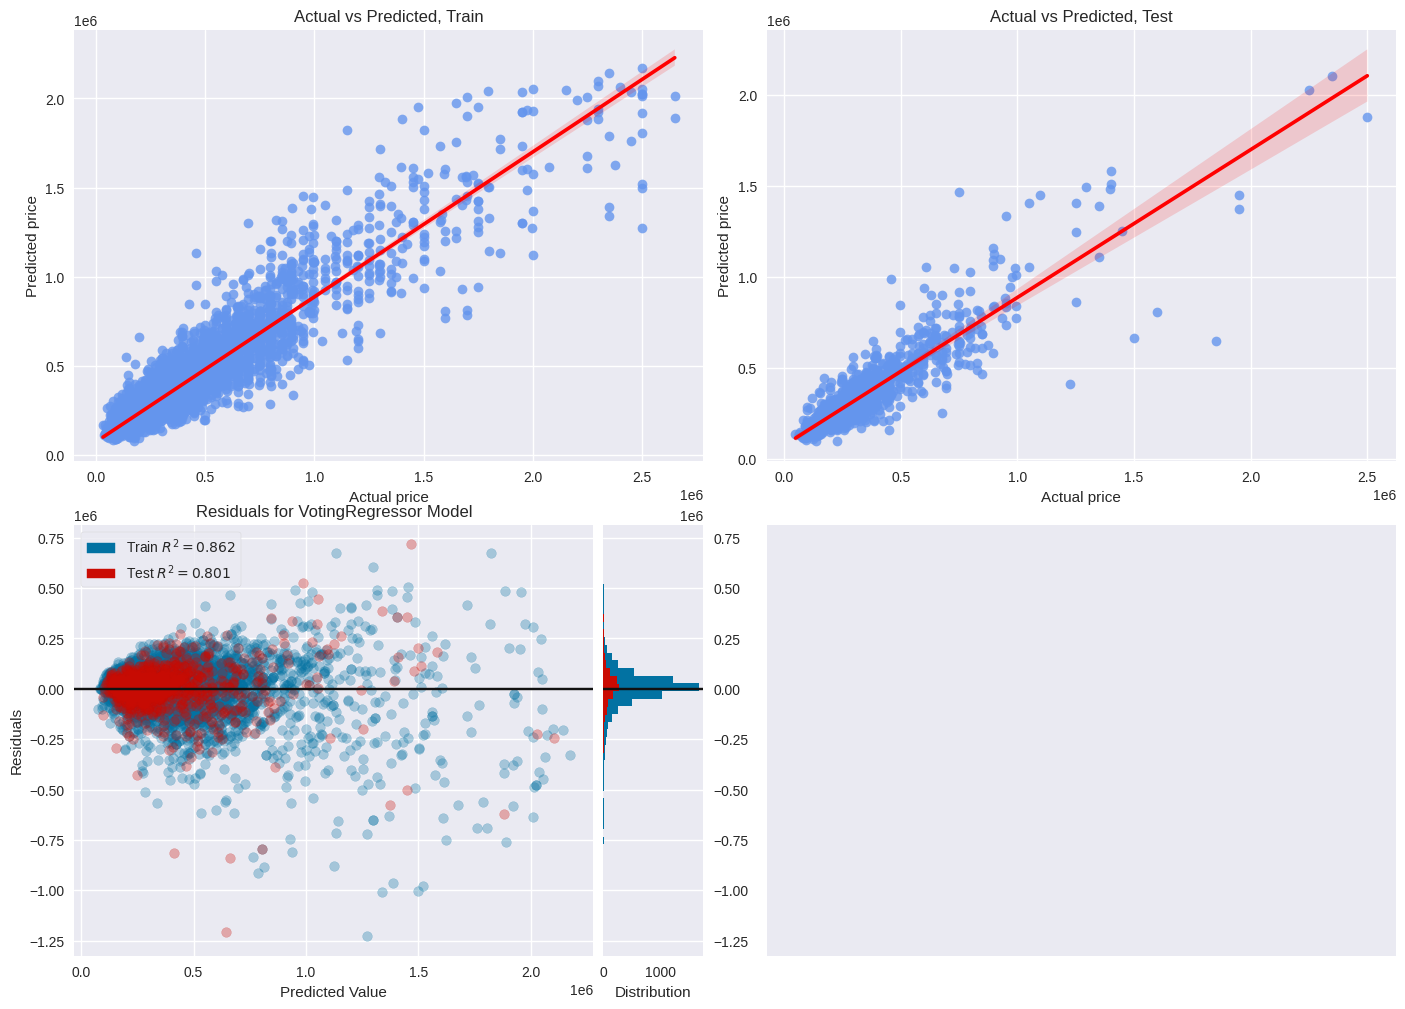

In [71]:
residuals(voting_regressor2, X_train, X_test, y_train, y_test)

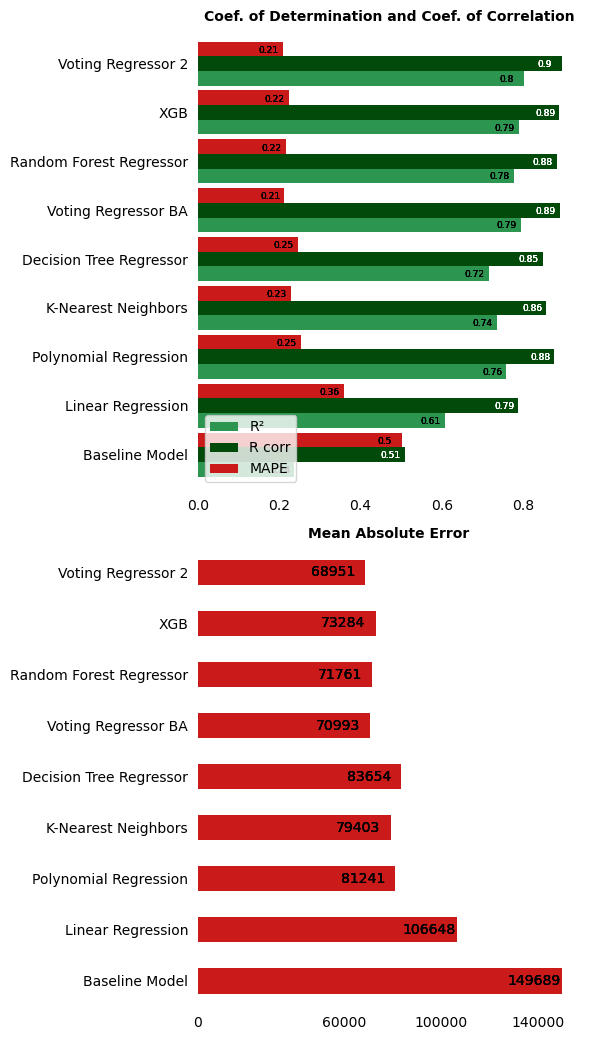

In [72]:
plot_metrics(metrics_to_plot)

In [90]:
comp_met(metrics_to_plot, 'Voting Regressor 2', 'Voting Regressor BA')

Improvement respect Baseline Model: 80739€ -> 54%
Improvement respect Last Best Model: 2042€ -> 3%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|80,739€|2,042€|
|54%|3%|

## Stacking

To finish let's train a Stacking model. It will be made up the Voting Regressor with Basic Algorithms and the Extreme Gradient Boosting.

- Regression Meta-Model: Linear Reagression

In [73]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
 #   level0.append(('voting_regressor_BA', voting_regressor_BA))
    level0.append(('poly', polyr))
    level0.append(('rfr', rfr))
    level0.append(('xgb', xgb_pipe_estimator))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [74]:
models_dict = {
#    'Voting Regressor BA': voting_regressor_BA, 
    'Polynomial Regression': polyr,
    'Random Forest Regressor': rfr, 
    'XGBoost': xgb_pipe_estimator,
    'Stacking': get_stacking()}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=6, 
                            return_train_score=False)

Polynomial Regression
r2 mean: -173073866065794.3
MAE mean: -50554012079.379395
----------
Random Forest Regressor
r2 mean: 0.7972481964811244
MAE mean: -80100.63331984098
----------
XGBoost
r2 mean: 0.7978100554688163
MAE mean: -83477.50222060627
----------
Stacking
r2 mean: -5890322739408.874
MAE mean: -9326363354.843863
----------


### Overfitting Analysis

In [75]:
stacking = get_stacking()
stacking.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = stacking.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = stacking.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Stacking Model'] = metrics

Performance on the training set:
 ----------
R²: 0.8640913636582354
MAE: 70173.74849261268
MAPE: 0.20278115875980615
RMSE: 112088.54807282318
R (corr): 0.9298657593349141

Performance on the test set:
 ----------
R²: 0.7989892096096238
MAE: 69879.17395653001
MAPE: 0.20913413032085992
RMSE: 114335.96635169035
R (corr): 0.8957321403092801



### Residuals Diagnostic

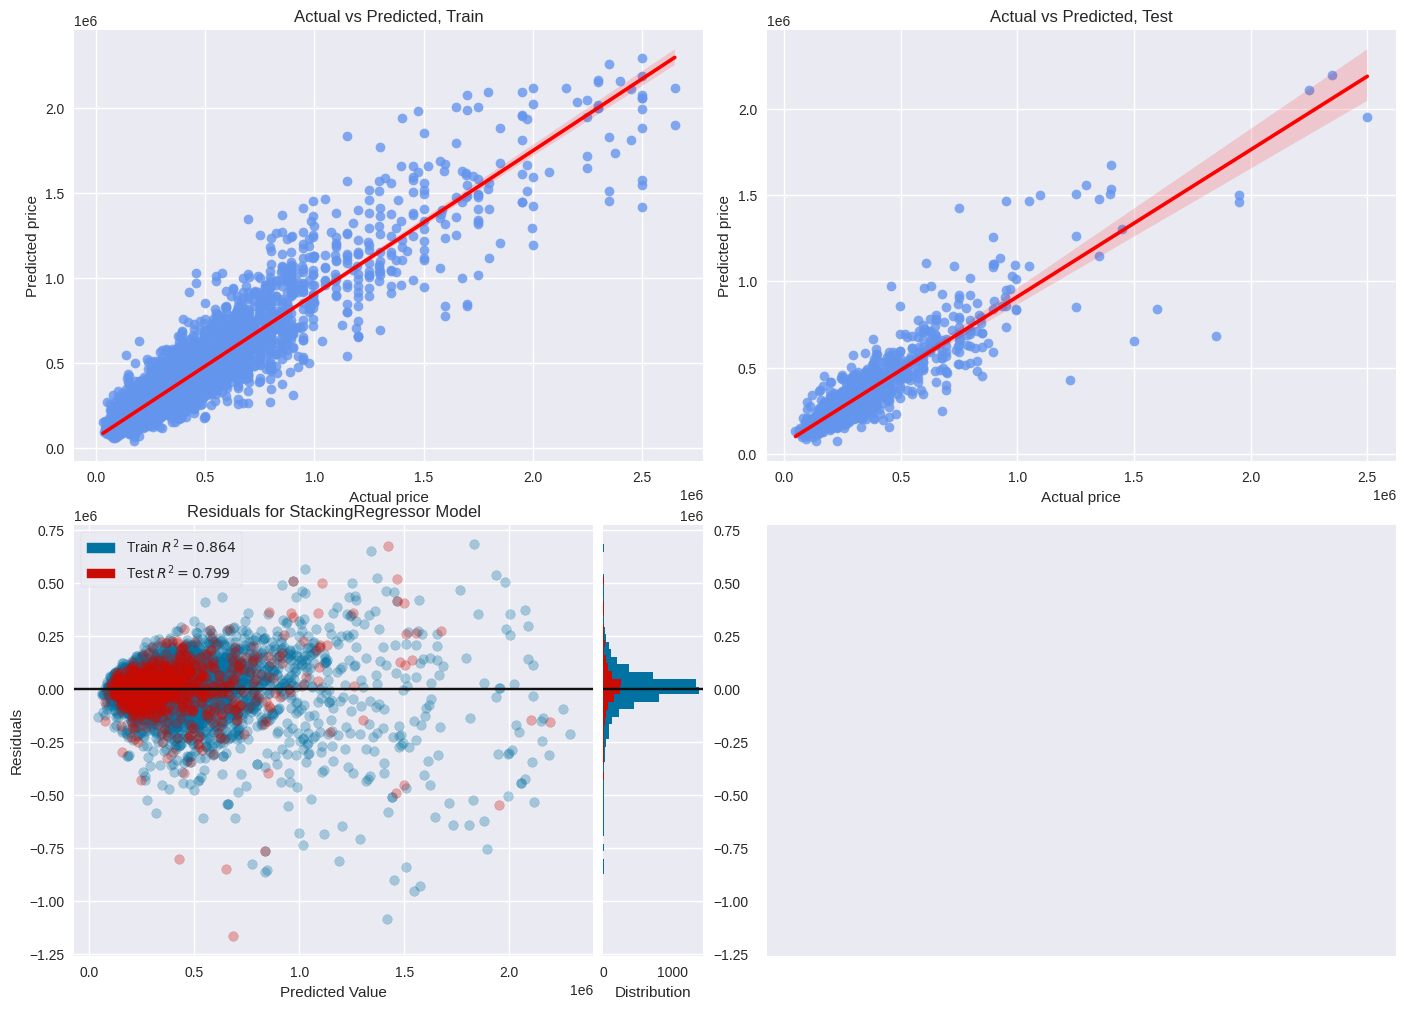

In [76]:
residuals(stacking, X_train, X_test, y_train, y_test)

**Conclusions**
- We have got some good performance in exchange of supporting more complexity.
- Following the same line as the previous models, the model's performance is better predicting houses prices cheapper than a million euros than highers as well.
- The tendency to understimate high values is still there.

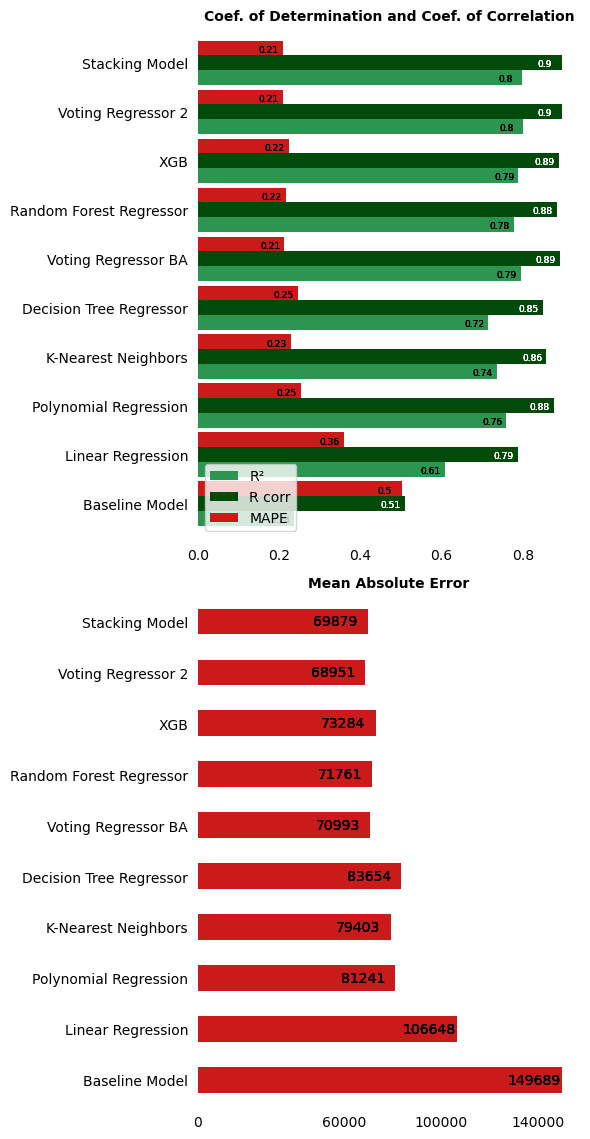

In [77]:
plot_metrics(metrics_to_plot)

In [91]:
comp_met(metrics_to_plot, 'Stacking Model', 'Voting Regressor 2')

Improvement respect Baseline Model: 79810€ -> 53%
Improvement respect Last Best Model: -929€ -> -1%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|79,810€|-929€|
|53%|-1%|

# Conclusions and Model Selection

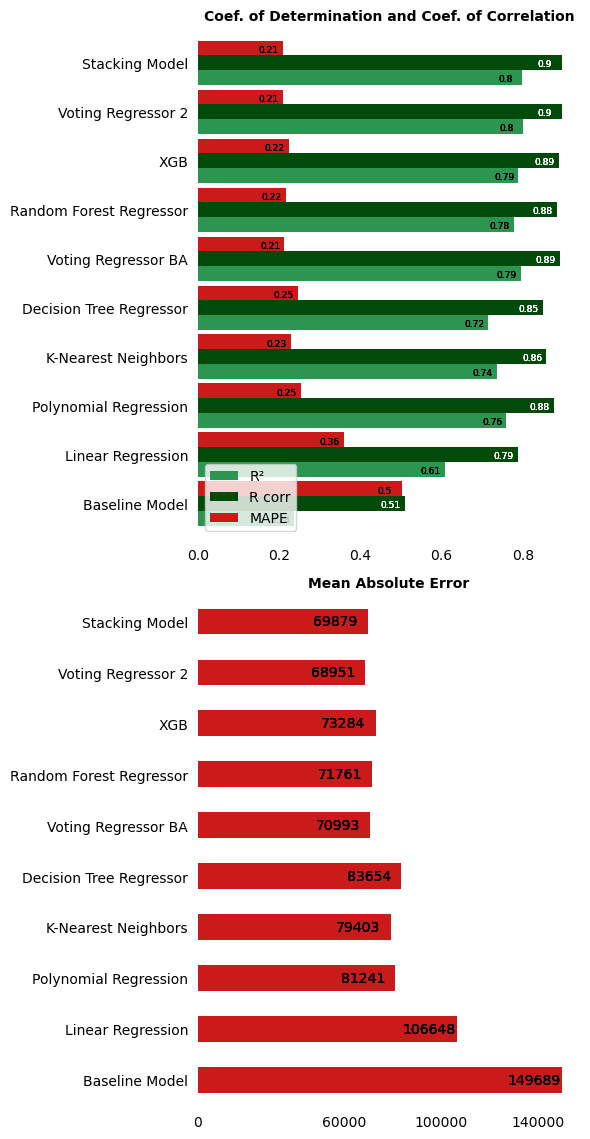

In [78]:
plot_metrics(metrics_to_plot=metrics_to_plot)

metrics_to_plotuce some conclusions from the work done in this notebooks.

- The best models obtain an r2 around 0.8 so those models are able to explain an 80% of the variability in prices. In Mean Absolute Error terms this is an error of 69,700€ aproximately when we try its performance in test set. This is not a super good score but it is not very bad as well taking into account the low number of features we are worked with.

- As we were increasing the complexity of the models the performance went up but the improvement wasn't to high so we will need to take a conciencious decision about what model we will use to predict the haouses' prices.

- Most of models tend to understimate houses prices which actual prices are over a million euros. Despite most houses are in the range price under a million this is still worrying. Our models are able to learn the relationship between preditor variables and the response variable better when the actual price of the house is under a million. That could be due to a lack of samples of expensive houses or due to a lack of predictors that can explain better the relationship with the price when it is too much high. Some predictors that perhaps explain that expensive prices could be the house year of construction, the anual income of residents in areas with expensive prices, etc. Also it may be possible that there is no predictors that explain those prices well which would mean that those expensive prices are absolutely disproportionate. 

- Another important aspect is the type of error that is less dangerous. Our model will be used to find potential investment opportunities which means that if the model understimates a house price that house would be less interesting to us as investemnt opportunity, discouraging us to invest money in that operation. That means that we would not win money but we would not loss it either. However, if the model tends to overstimate the price of a house it would be encouraging us to invest in that house so we could buy an asset which value is lower than its price. That means that we could loss money. So we can conclude that a model that tends to understimate asset prices is less dangerous to us that one that tends to overstimate them.

- Some future steps to improve our capability to predict houses prices are the following:
    - Obtain more information from the current variables we have. We could cluster the data or try to combine a few variables to get others with more predicting power.
    - Obtain more information from the current variables we have and other information we don't have as demographic data, income level per capita per area or city, distance from houses to diferent points of interest (schools, museums, universities, public transport, etc), weather data, etc.
    - Also we could try to develop different models for houses with prices under or over a million euros to figure out if it can perform better.
    - Finally we could try deep learning techniques to figure out the performance.
    
   
By the moment we will use the stacking model with a level 0 made up of a voting regressor with basic algorithms and an extreme gradient boosting and a linear regression as meta-model.

## Fails

**Metrics with Clusters**

They are a little bit better with some algorithms and a little bit worse with others. As the best model is the Voting Regressor 2 and it perfoms worse with the cluster column I decided to drop that column. 

![](https://raw.githubusercontent.com/javiicc/Identifyin_Potential_Investment_Opportunities_In_The_Irish_Real_Estate_Market_Using_Machine_Learning/docuanddebugging/investment-opportunities/notebooks/imgs/mae_w_clusters.png)

**Metrics Dropping Missing Values**

If the missing values are dropped at the beginning of the notebook it would reduce the number of samples from 7344 to 5778. The resulting MAE would be significantly worse.

![]()

****

# Save Stacking Model

Before saving the winner model we will fit it to all the data instead only the training set. 

In [79]:
# Split data in predictors and target
X, y = split_data(data=data, 
                  target='price', 
                  test_size=.15, 
                  output='X_y',
                  random_state=7)

X: (7344, 7)
y: (7344,)


In [80]:
# Get the stacking model we created earlier
houses_prices_stacking_model = get_stacking()
# Fit the model to all the data
houses_prices_stacking_model.fit(X, y)

StackingRegressor(cv=5,
                  estimators=[('poly',
                               Pipeline(steps=[('preprocessor',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('num',
                                                                                 Pipeline(steps=[('power_transformer',
                                                                                                  PowerTransformer()),
                                                                                                 ('poly',
                                                                                                  PolynomialFeatures(degree=4,
                                                                                                                     include_bias=False))]),
                                                                                 [

In [81]:
joblib.dump(houses_prices_stacking_model, 'models/houses_prices_stacking_model.plk')

['models/houses_prices_stacking_model.plk']

In [82]:
model = joblib.load('models/houses_prices_stacking_model.plk')
# model

# Prepare Data for Plotly Dash 

Now we have a trained model that we can use to predict prices. Here we will be using the data the model was trained with as is the data we have, but the model is useful to predict current unseen data from the real market. 

In [83]:
y_pred = model.predict(X)
# We convert y_pred to a list to avoid a problem with nan values
data['predicted_price'] = list(y_pred) 
# The residual is what will tell us whether the asset is a potential opportunity
data['residual'] = data.predicted_price - data.price
data['res_percentage'] = data.residual / data.price

As we are calculating the residuals extracting the  actual price from the predicted one, if the residual is a positive number it means that the predicted price is higher than the actual one so the asset could be an investment opportunity. 

We can see different examples of how the final DataFrame is running the cell below.

In [84]:
data.sample()

,price,floor_area,latitude,longitude,bedroom,bathroom,type_house,place,predicted_price,residual,res_percentage
6860,140000.0,130,53.765322,-8.480101,4,3,house,Castlerea,175556.464783,35556.464783,0.253975


After running the cell above several times I have realised that I should research more in depth the resulting DataFrame to try to figure out why some houses are better predicted and why others are not.

In [85]:
data.to_csv('data/data_predicted.csv', sep=',', index=False)